In [2]:
## Notebook env: mave (mave kernel)
import os
os.chdir('/home/ssobti/projects/mir_tud/packages/ciberatac-main/src/mave')
import pandas as pd
import numpy as np
import scanpy as sc
import itertools
import pickle
import shelve

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 pynndescent==0.5.8


In [4]:
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/miR.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [5]:
### feed in raw matrix (adata.X) into VAE with filter out cells with low # genes and genes expressed in low # of cells
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 30035 × 36601
    obs: 'sample', 'barcode', 'guide', 'lor', 'pvalue', 'adj_pvalue', 'max_umi', 'n_umi', 'm_umi', 'v_umi', 'log_max_umi', 'log_n_umi', 'log_m_umi'
    var: 'feature_type'

normalizing counts per cell
    finished (0:00:01)


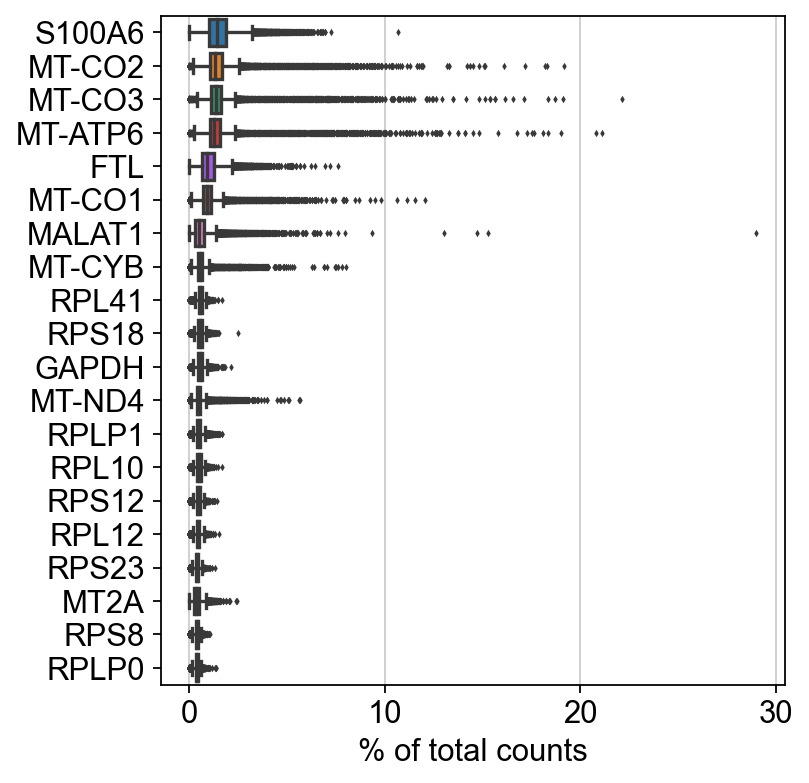

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 6345 genes that are detected in less than 3 cells


In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

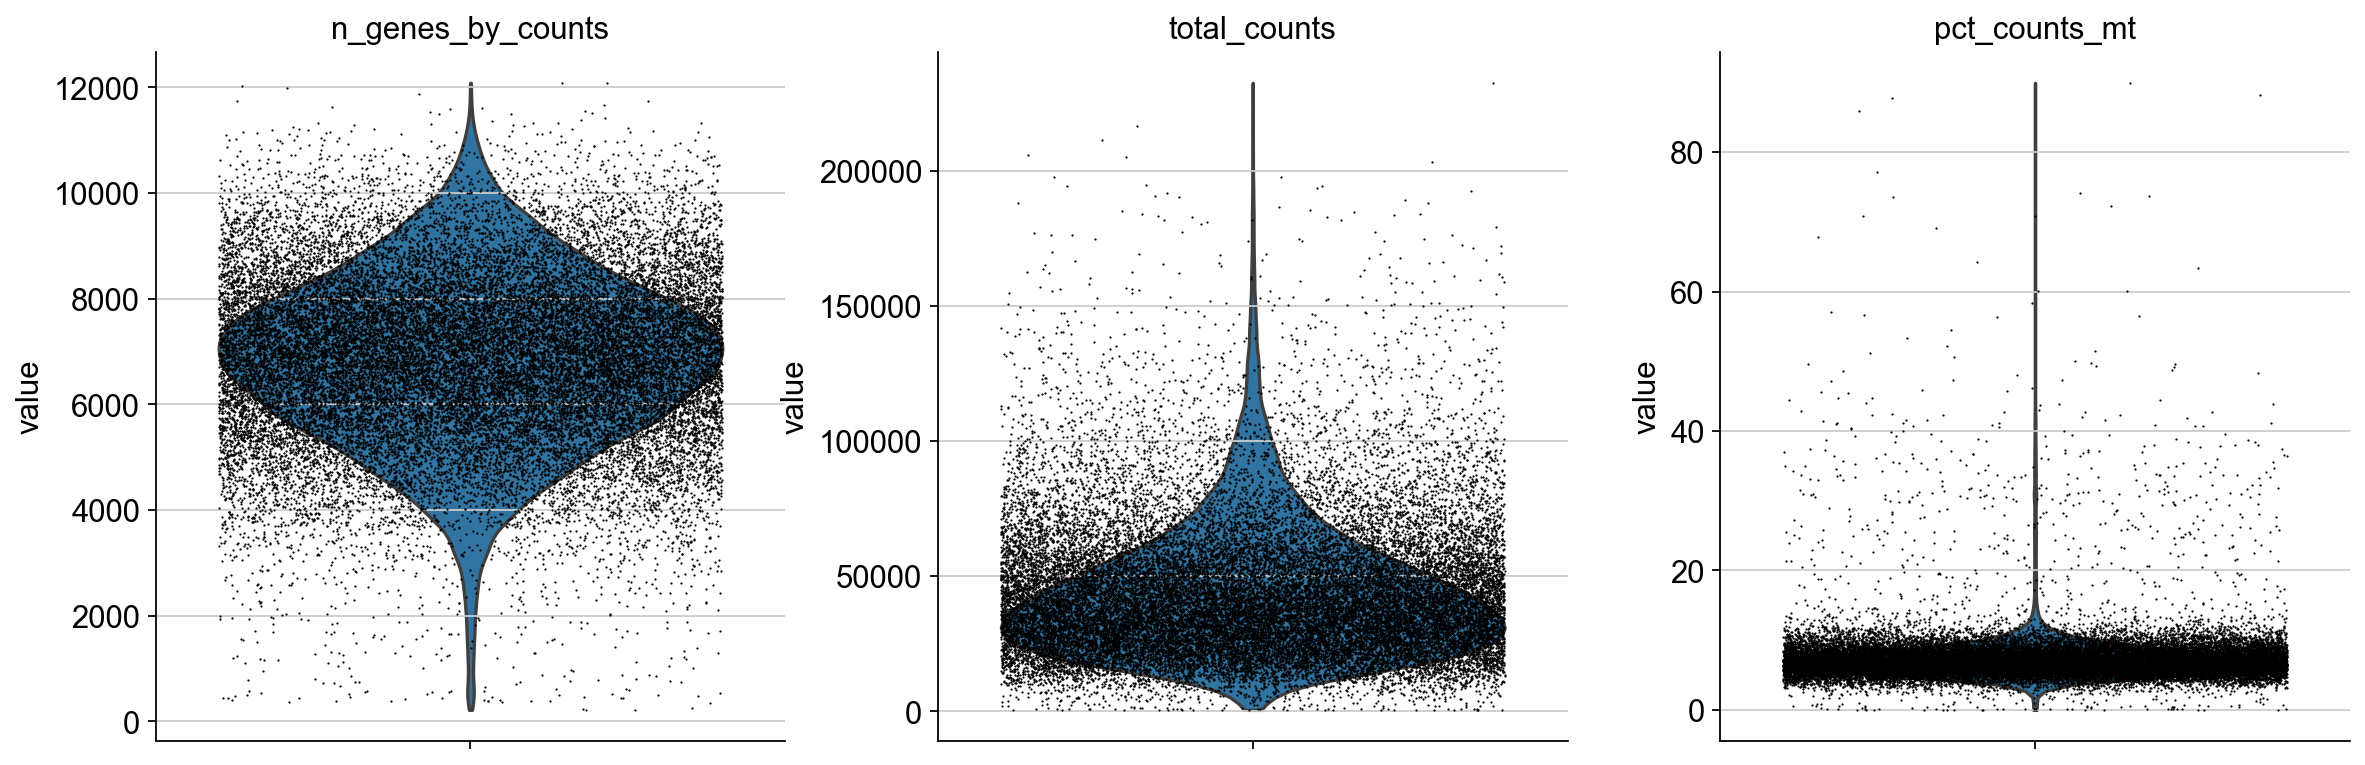

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

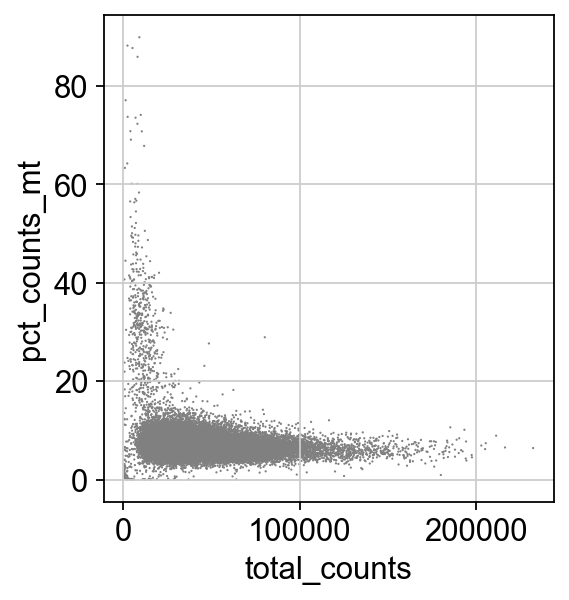

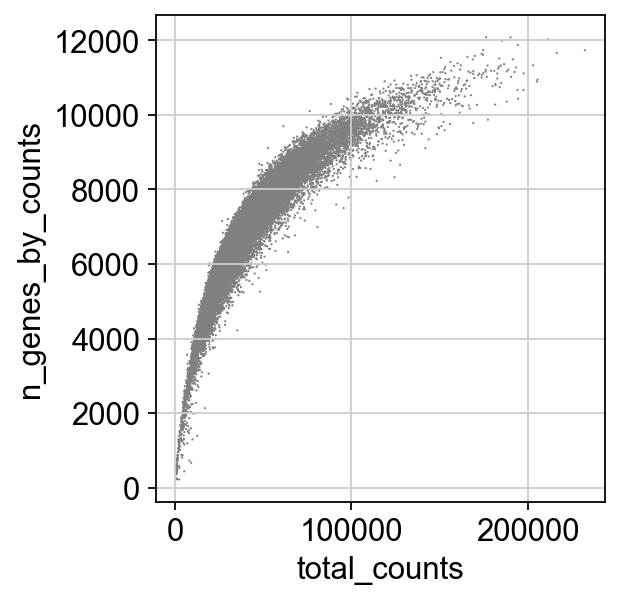

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
adata = adata[adata.obs.pct_counts_mt < 12, :]

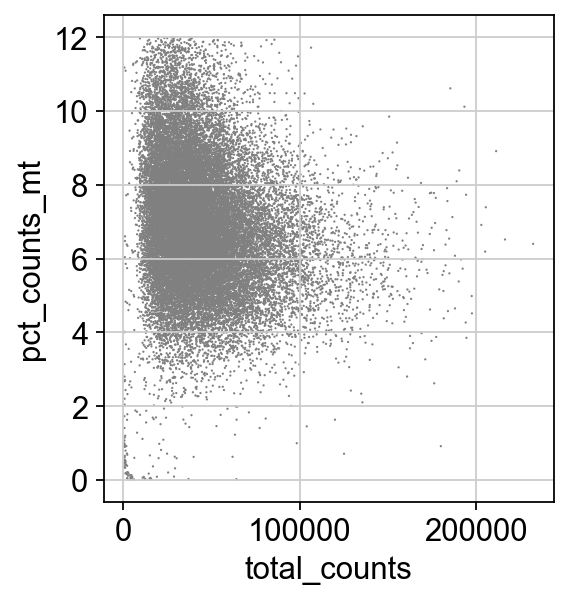

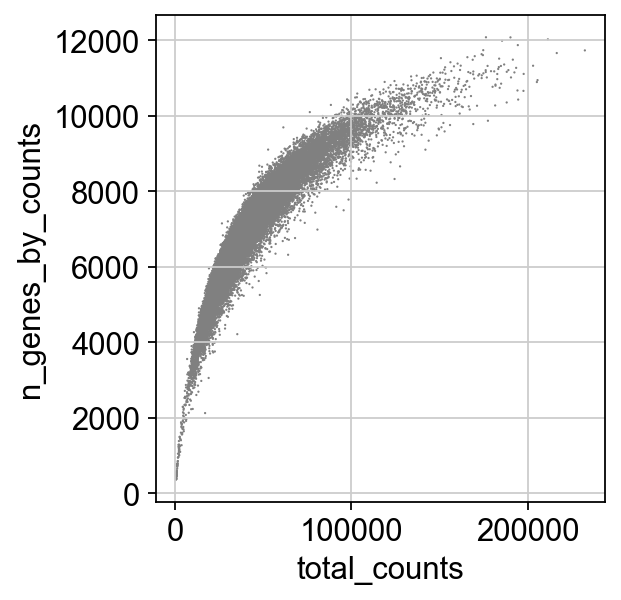

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
### remove ('hsa-miR-92a-3p', ['miR_1:TCACAAGTCGGCATAT-1']) from adata
cells_to_keep = [cell for cell in adata.obs.index.to_list() if cell != 'miR_1:TCACAAGTCGGCATAT-1']
adata = adata[cells_to_keep,:]

In [15]:
adata.obs

sample           barcode             guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  miR_1  AAACCCAAGGAGAGGC   hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  miR_1  AAACCCAAGGTAAACT     hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  miR_1  AAACCCACAACGATCT   hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  miR_1  AAACCCACACGATTCA         TuD_NC_18  5.859895   
miR_1:AAACCCACAGTCAACT-1  miR_1  AAACCCACAGTCAACT   hsa-miR-147b-5p  5.632808   
...                         ...               ...               ...       ...   
miR_3:TTTGGTTTCGGACTTA-1  miR_3  TTTGGTTTCGGACTTA    hsa-miR-616-5p  3.885564   
miR_3:TTTGTTGCACGCGTGT-1  miR_3  TTTGTTGCACGCGTGT    hsa-miR-361-5p  0.506602   
miR_3:TTTGTTGCATAGATCC-1  miR_3  TTTGTTGCATAGATCC   hsa-miR-548o-3p  6.603449   
miR_3:TTTGTTGGTCTAGTGT-1  miR_3  TTTGTTGGTCTAGTGT   hsa-miR-3940-5p  2.402414   
miR_3:TTTGTTGGTTTCCATT-1  miR_3  TTTGTTGGTTTCCATT  hsa-miR-10527-5p  6.014592   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0   78.0   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  108.0   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  113.0   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  114.0   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0   86.0   
...                                 ...            ...      ...    ...   
miR_3:TTTGGTTTCGGACTTA-1  8.005527e-277  6.410418e-270    129.0  237.0   
miR_3:TTTGTTGCACGCGTGT-1   8.834341e-07   1.000000e+00      2.0   12.0   
miR_3:TTTGTTGCATAGATCC-1  5.795787e-306  4.640971e-299    126.0  159.0   
miR_3:TTTGTTGGTCTAGTGT-1  5.349572e-125  4.283664e-118     58.0  110.0   
miR_3:TTTGTTGGTTTCCATT-1  4.169835e-209  3.338991e-202    101.0  131.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   
...                            ...        ...          ...        ...   
miR_3:TTTGGTTTCGGACTTA-1  0.596977  44.983627     2.110590   2.374748   
miR_3:TTTGTTGCACGCGTGT-1  0.030227   0.034438     0.301030   1.079181   
miR_3:TTTGTTGCATAGATCC-1  0.400504  40.028586     2.100371   2.201397   
miR_3:TTTGTTGGTCTAGTGT-1  0.277078   9.251317     1.763428   2.041393   
miR_3:TTTGTTGGTTTCCATT-1  0.329975  25.736801     2.004321   2.117271   

                          log_m_umi  n_genes  n_genes_by_counts  total_counts  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696     6001               6001       33957.0   
miR_1:AAACCCAAGGTAAACT-1  -0.565367     6871               6870       31930.0   
miR_1:AAACCCACAACGATCT-1  -0.545712     7448               7448       42786.0   
miR_1:AAACCCACACGATTCA-1  -0.541886     8043               8042       58540.0   
miR_1:AAACCCACAGTCAACT-1  -0.664292     6582               6582       31581.0   
...                             ...      ...                ...           ...   
miR_3:TTTGGTTTCGGACTTA-1  -0.224042     5525               5525       25937.0   
miR_3:TTTGTTGCACGCGTGT-1  -1.519609     8828               8828       82117.0   
miR_3:TTTGTTGCATAGATCC-1  -0.397393     6431               6431       34834.0   
miR_3:TTTGTTGGTCTAGTGT-1  -0.557398     5103               5103       22318.0   
miR_3:TTTGTTGGTTTCCATT-1  -0.481519     5082               5082       19834.0   

                          total_counts_mt  pct_counts_mt  
miR_1:AAACCCAAGGAGAGGC-1           2912.0       8.575551  
miR_1:AAACCCAAGGTAAACT-1           2091.0       6.548700  
miR_1:AAACCCACAACGATCT-1           3784.0       8.844014  
miR_1:AAACCCACACGATTCA-1           5896.0      10.071746  
miR_1:AAACCCACAGTC

In [16]:
### pertubation annotation to add to each cell
one_hot_df = pd.get_dummies(adata.obs["guide"])

In [17]:
one_hot_df

TuD_NC_01  TuD_NC_02  TuD_NC_03  TuD_NC_04  \
miR_1:AAACCCAAGGAGAGGC-1          0          0          0          0   
miR_1:AAACCCAAGGTAAACT-1          0          0          0          0   
miR_1:AAACCCACAACGATCT-1          0          0          0          0   
miR_1:AAACCCACACGATTCA-1          0          0          0          0   
miR_1:AAACCCACAGTCAACT-1          0          0          0          0   
...                             ...        ...        ...        ...   
miR_3:TTTGGTTTCGGACTTA-1          0          0          0          0   
miR_3:TTTGTTGCACGCGTGT-1          0          0          0          0   
miR_3:TTTGTTGCATAGATCC-1          0          0          0          0   
miR_3:TTTGTTGGTCTAGTGT-1          0          0          0          0   
miR_3:TTTGTTGGTTTCCATT-1          0          0          0          0   

                          TuD_NC_05  TuD_NC_06  TuD_NC_07  TuD_NC_08  \
miR_1:AAACCCAAGGAGAGGC-1          0          0          0          0   
miR_1:AAACCCAAGGTAAACT-1          0          0          0          0   
miR_1:AAACCCACAACGATCT-1          0          0          0          0   
miR_1:AAACCCACACGATTCA-1          0          0          0          0   
miR_1:AAACCCACAGTCAACT-1          0          0          0          0   
...                             ...        ...        ...        ...   
miR_3:TTTGGTTTCGGACTTA-1          0          0          0          0   
miR_3:TTTGTTGCACGCGTGT-1          0          0          0          0   
miR_3:TTTGTTGCATAGATCC-1          0          0          0          0   
miR_3:TTTGTTGGTCTAGTGT-1          0          0          0          0   
miR_3:TTTGTTGGTTTCCATT-1          0          0          0          0   

                          TuD_NC_09  TuD_NC_10  ...  hsa-miR-6783-3p  \
miR_1:AAACCCAAGGAGAGGC-1          0          0  ...                0   
miR_1:AAACCCAAGGTAAACT-1          0          0  ...                0   
miR_1:AAACCCACAACGATCT-1          0          0  ...                0   
miR_1:AAACCCACACGATTCA-1          0          0  ...                0   
miR_1:AAACCCACAGTCAACT-1          0          0  ...                0   
...                             ...        ...  ...              ...   
miR_3:TTTGGTTTCGGACTTA-1          0          0  ...                0   
miR_3:TTTGTTGCACGCGTGT-1          0          0  ...                0   
miR_3:TTTGTTGCATAGATCC-1          0          0  ...                0   
miR_3:TTTGTTGGTCTAGTGT-1          0          0  ...                0   
miR_3:TTTGTTGGTTTCCATT-1          0          0  ...                0   

                          hsa-miR-7706  hsa-miR-7974  hsa-miR-9903  \
miR_1:AAACCCAAGGAGAGGC-1             0             0             0   
miR_1:AAACCCAAGGTAAACT-1             0             0             0   
miR_1:AAACCCACAACGATCT-1             0             0             0   
miR_1:AAACCCACACGATTCA-1             0             0             0   
miR_1:AAACCCACAGTCAACT-1             0             0             0   
...                                ...           ...           ...   
miR_3:TTTGGTTTCGGACTTA-1             0             0             0   
miR_3:TTTGTTGCACGCGTGT-1             0             0             0   
miR_3:TTTGTTGCATAGATCC-1             0             0             0   
miR_3:TTTGTTGGTCTAGTGT-1             0             0             0   
miR_3:TTTGTTGGTTTCCATT-1             0             0             0   

                          hsa-miR-10399-3p  hsa-miR-10399-5p  \
miR_1:AAACCCAAGGAGAGGC-1                 0                 0   
miR_1:AAACCCAAGGTAAACT-1                 0                 0   
miR_1:AAACCCACAACGATCT-1                 0                 0   
miR_1:AAACCCACACGATTCA-1                 0                 0   
miR_1:AAACCCACAGTCAACT-1                 0                 0   
...                                    ...               ...   
miR_3:TTTGGTTTCGGACTTA-1                 0                 0   
miR_3:TTTGTTGCACGCGTGT-1                 0                 0   
miR_3:TTTGTTGC

In [18]:
## add the gene annotation for the first layer
## the first layer is connected to the second in a way such that reflects pathways
## RBP_gene_df is the gene connections (first layer) to TFs (second layer) gmt file

In [19]:
import scipy.sparse as sp_sparse
import tables
from itertools import chain
from model import loss_function
from model import VAE
import numpy as np
import os
import pandas as pd
import torch
from gseapy import read_gmt
from datetime import datetime


In [20]:
gmt_file = read_gmt('/home/ssobti/projects/mir_tud/uploaded_data/c3.all.v2022.1.Hs.symbols.gmt')

In [21]:
### creating a matrix that links gene sets (columns) to master regulators (rows) via 0/1 annotation
gmt_file = pd.Series(gmt_file).str.join('|')
gmt_file = gmt_file.str.get_dummies()
gmt_file

A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2MP1  \
MIR153_5P                0         0     1    0        0      0      0   
MIR8485                  0         0     0    0        0      0      0   
MIR3662                  0         0     0    0        0      0      0   
MIR607                   0         0     0    0        0      0      0   
MIR616_5P                0         0     0    0        0      0      0   
...                    ...       ...   ...  ...      ...    ...    ...   
E2F1_Q4_01               0         0     0    0        0      0      0   
E2F1_Q6_01               0         0     0    0        0      0      0   
KTGGYRSGAA_UNKNOWN       0         0     0    0        0      0      0   
RRCCGTTA_UNKNOWN         0         0     0    0        0      0      0   
SGCGSSAAA_E2F1DP2_01     0         0     0    0        0      0      0   

                      A3GALT2  A4GALT  A4GNT  ...  ZWINT  ZXDA  ZXDB  ZXDC  \
MIR153_5P                   0       0      0  ...      0     0     0     0   
MIR8485                     0       0      0  ...      0     1     0     0   
MIR3662                     0       0      0  ...      0     0     0     0   
MIR607                      0       0      0  ...      0     0     0     1   
MIR616_5P                   0       0      0  ...      0     0     0     0   
...                       ...     ...    ...  ...    ...   ...   ...   ...   
E2F1_Q4_01                  0       0      0  ...      0     0     0     0   
E2F1_Q6_01                  0       0      0  ...      0     0     0     0   
KTGGYRSGAA_UNKNOWN          0       0      0  ...      0     0     0     0   
RRCCGTTA_UNKNOWN            0       0      0  ...      0     0     0     0   
SGCGSSAAA_E2F1DP2_01        0       0      0  ...      0     0     0     0   

                      ZYG11A  ZYG11AP1  ZYG11B  ZYX  ZZEF1  ZZZ3  
MIR153_5P                  0         0       0    0      0     0  
MIR8485                    0         0       1    0      0     0  
MIR3662                    0         0       0    0      0     0  
MIR607                     0         0       0    0      0     0  
MIR616_5P                  0         0       0    0      0     0  
...                      ...       ...     ...  ...    ...   ...  
E2F1_Q4_01                 0         0       0    0      0     0  
E2F1_Q6_01                 0         0       0    0      0     0  
KTGGYRSGAA_UNKNOWN         0         0       0    0      0     0  
RRCCGTTA_UNKNOWN           0         0       0    0      0     0  
SGCGSSAAA_E2F1DP2_01       0         0       0    0      0     0  

[3725 rows x 27990 columns]

In [22]:
## remove genes not in intersection bw expression matrix and gene_set annotation df
a = set(gmt_file.columns.to_list())
b = set(adata.var.index.to_list())

intersecting_genes = list(a.intersection(b))
print('Genes in annotated gene sets', len(a))
print('Genes in expression matrix', len(b))
print('Union', len(a.union(b)))
print('Intersecting genes kept', len(a.intersection(b)))

adata = adata[:, intersecting_genes]
gmt_file = gmt_file.loc[:, intersecting_genes]

Genes in annotated gene sets 27990
Genes in expression matrix 30256
Union 39173
Intersecting genes kept 19073


In [23]:
gmtmat_df = gmt_file.transpose()
gmtmat_df

MIR153_5P  MIR8485  MIR3662  MIR607  MIR616_5P  MIR371B_5P  \
RAB11B-AS1          0        0        0       0          0           0   
NIP7                0        0        0       0          0           0   
SCN3B               0        0        0       0          1           1   
MED13L              1        0        0       0          0           0   
YES1                0        0        0       0          0           0   
...               ...      ...      ...     ...        ...         ...   
RSPH10B             0        0        0       0          0           0   
ZNF638              0        0        0       0          0           0   
MSTN                0        0        1       0          0           0   
VLDLR               0        0        0       0          0           0   
DYRK1B              0        0        0       0          0           0   

            MIR373_5P  MIR6867_5P  MIR12136  MIR548AJ_3P_MIR548X_3P  ...  \
RAB11B-AS1          0           0         0                       0  ...   
NIP7                0           0         0                       0  ...   
SCN3B               1           0         0                       0  ...   
MED13L              0           0         1                       1  ...   
YES1                0           0         1                       1  ...   
...               ...         ...       ...                     ...  ...   
RSPH10B             0           0         0                       0  ...   
ZNF638              0           0         0                       0  ...   
MSTN                0           0         0                       1  ...   
VLDLR               0           0         0                       0  ...   
DYRK1B              0           0         0                       0  ...   

            E2F1DP1RB_01  E2F_Q3_01  E2F_Q4_01  E2F_Q6_01  E2F1_Q3_01  \
RAB11B-AS1             0          0          0          0           0   
NIP7                   0          0          0          0           0   
SCN3B                  0          0          0          0           0   
MED13L                 0          0          0          0           0   
YES1                   0          0          0          0           0   
...                  ...        ...        ...        ...         ...   
RSPH10B                0          0          0          0           0   
ZNF638                 0          0          0          0           0   
MSTN                   0          0          0          0           0   
VLDLR                  0          0          0          0           0   
DYRK1B                 0          0          0          0           0   

            E2F1_Q4_01  E2F1_Q6_01  KTGGYRSGAA_UNKNOWN  RRCCGTTA_UNKNOWN  \
RAB11B-AS1           0           0                   0                 0   
NIP7                 0           0                   0                 0   
SCN3B                0           0                   0                 0   
MED13L               0           0                   0                 0   
YES1                 0           0                   0                 0   
...                ...         ...                 ...               ...   
RSPH10B              0           0                   0                 0   
ZNF638               0           0                   0                 0   
MSTN                 0           0                   0                 0   
VLDLR                0           0                   0                 0   
DYRK1B               0           0                   0                 0   

            SGCGSSAAA_E2F1DP2_01  
RAB11B-AS1                     0  
NIP7                           0  
SCN3B                          0  
MED13L                         0  
YES1                           0  
...                          ...  
RSPH10B                        0  
ZNF638                         0  
MSTN                           0  
VLDLR                          0  
DYRK1B                         0  


In [24]:
gmtmat = gmtmat_df.to_numpy()
gmtmat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
device='cpu'

In [26]:
gmttensor = torch.from_numpy(
            np.transpose(gmtmat)).to(device).long()
gmttensor

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [27]:
## this function tells you how many paramters are in a model
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

# Twin Model

In [28]:
import random
samps=random.sample(list(adata.obs.guide.unique()),2)
samps

['hsa-miR-653-3p', 'hsa-miR-1301-3p']

In [29]:
adata.obs.index

Index(['miR_1:AAACCCAAGGAGAGGC-1', 'miR_1:AAACCCAAGGTAAACT-1',
       'miR_1:AAACCCACAACGATCT-1', 'miR_1:AAACCCACACGATTCA-1',
       'miR_1:AAACCCACAGTCAACT-1', 'miR_1:AAACCCACATCTCATT-1',
       'miR_1:AAACCCACATGTCGTA-1', 'miR_1:AAACCCACATTATGCG-1',
       'miR_1:AAACCCAGTCTAATCG-1', 'miR_1:AAACCCAGTTAATCGC-1',
       ...
       'miR_3:TTTGGAGTCTTCACGC-1', 'miR_3:TTTGGTTAGGCGACAT-1',
       'miR_3:TTTGGTTCAACGACTT-1', 'miR_3:TTTGGTTCATAGCTGT-1',
       'miR_3:TTTGGTTTCCTTACCG-1', 'miR_3:TTTGGTTTCGGACTTA-1',
       'miR_3:TTTGTTGCACGCGTGT-1', 'miR_3:TTTGTTGCATAGATCC-1',
       'miR_3:TTTGTTGGTCTAGTGT-1', 'miR_3:TTTGTTGGTTTCCATT-1'],
      dtype='object', length=29147)

In [30]:
ct_cbc_dict = {}
cbc_ct_dict = {}
for ct in list(adata.obs.guide.unique()):
    ct_cbc_dict[ct] = adata.obs.query(f'guide==\"{ct}\"').index.tolist()
    for cbc in ct_cbc_dict[ct]:
        cbc_ct_dict[cbc] = ct
list(ct_cbc_dict.items())[1]

('hsa-miR-93-3p',
 ['miR_1:AAACCCAAGGTAAACT-1',
  'miR_1:AAGTACCGTATCAGCT-1',
  'miR_1:AAGTCGTGTGTCATTG-1',
  'miR_1:ACCTGTCGTGTGTGGA-1',
  'miR_1:ACGTAACTCTCCAAGA-1',
  'miR_1:ACGTACAGTGTGTCGC-1',
  'miR_1:ACTTCCGAGTGATCGG-1',
  'miR_1:AGGTTACTCCGATAAC-1',
  'miR_1:ATTTCACCAGCGAACA-1',
  'miR_1:CACATGAGTCGACTTA-1',
  'miR_1:CACATGATCCGCAACG-1',
  'miR_1:CAGATACCACTAAACC-1',
  'miR_1:CAGCACGTCCATCTGC-1',
  'miR_1:CATGCCTGTCGAGTGA-1',
  'miR_1:CGTAATGCACAATGTC-1',
  'miR_1:CGTGATAAGAGAGGGC-1',
  'miR_1:CTAACCCAGGTTGACG-1',
  'miR_1:CTCATGCAGTAAGCAT-1',
  'miR_1:GACCCAGAGCATCAAA-1',
  'miR_1:GACCCTTTCGCTATTT-1',
  'miR_1:GGATCTAGTGTATACC-1',
  'miR_1:GGCTTGGCATCCCACT-1',
  'miR_1:GGTGATTGTGGATACG-1',
  'miR_1:GGTTGTACATCCTCAC-1',
  'miR_1:GTGAGTTTCGTGGCGT-1',
  'miR_1:GTGCTTCCAATTTCTC-1',
  'miR_1:GTTTACTGTATAGCTC-1',
  'miR_1:GTTTGGATCCCTGTTG-1',
  'miR_1:TATGTTCGTATGAAGT-1',
  'miR_1:TATTGCTCAATCGCAT-1',
  'miR_1:TATTTCGCAGTTACCA-1',
  'miR_1:TCTACATGTTTACGTG-1',
  'miR_1:TGTTCCGCAATTG

In [31]:
list(cbc_ct_dict.items())[1]

('miR_1:AATGGCTAGCGAAACC-1', 'hsa-miR-203a-3p')

In [32]:
adata.X.toarray().shape

(29147, 19073)

In [33]:
adata.var.shape

(19073, 7)

In [34]:
## this converts the expression matrix to a dictionary 
## where each cell/row of matrix is now a 'key' with associated gene expression values

cbc_arr_dict = {}
for cbc, arr in zip(adata.obs.index.tolist(), adata.X.toarray()):
    cbc_arr_dict[cbc] = arr.copy()
list(cbc_arr_dict.items())[1]

('miR_1:AAACCCAAGGTAAACT-1',
 array([0., 2., 0., ..., 0., 1., 0.], dtype=float32))

In [35]:
## this converts the cell barcode to guide annotation df to a dictionary 
one_hot_dict = one_hot_df.T.to_dict(orient='list')
list(one_hot_dict.keys())[0]

'miR_1:AAACCCAAGGAGAGGC-1'

In [75]:
numlvs = 10
vae = VAE(adata.shape[1],  # num genes
              gmttensor, #gmttensor
              len(set(adata.obs["guide"])), #number of cell types
              0,  # batch
              0,  # labels
              gmtmat.shape[1],  # hiddensize
              numlvs)

n_params = get_n_params(vae)
print("VAE has {} parameters".format(n_params))
vae.to(device)

VAE has 355468020 parameters


VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=3725, out_features=10, bias=True)
    (var_encoder): Linear(in_features=3725, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=396, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linea

In [37]:
optimizer = torch.optim.Adam(
        vae.parameters(), lr=0.002)

SAMPLE_IDXS = adata.shape[0]

In [38]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

class tripletDataset(Dataset):
    def __init__(self, cbc_list, ct_list, ct_cbc_dict, cbc_ct_dict, cbc_arr_dict, one_hot_dict):
        self.cbc_list = cbc_list
        self.ct_list = ct_list
        self.ct_cbc_dict = ct_cbc_dict
        self.cbc_ct_dict = cbc_ct_dict
        self.cbc_arr_dict = cbc_arr_dict
        self.one_hot_dict = one_hot_dict
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        cbc_anchor = self.cbc_list[idx]
        ct_anchor = self.cbc_ct_dict[cbc_anchor]

        #for negative, pick two random cell types, in case the 1st one turned out to be the same as the anchor's cell type
        ct1, ct2 = random.sample(self.ct_list, 2) 
        ct_neg = ct1
        if ct1==ct_anchor:
            ct_neg = ct2
        
        #for positive, pick two cell barcodes, in case the 1st one turned out to be the anchor itself
        cbc1, cbc2 = random.sample(self.ct_cbc_dict[ct_anchor], 2)
        cbc_pos = cbc1
        if cbc1==cbc_anchor:
            cbc_pos = cbc2
        
        cbc_neg = random.choice(self.ct_cbc_dict[ct_neg])
        
        ohot_arr = np.array(self.one_hot_dict[cbc_anchor])
                
        return (torch.from_numpy(cbc_arr_dict[cbc_anchor].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_pos].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_neg].astype(np.float32)),
                torch.from_numpy(ohot_arr.astype(np.float32)))
    
    def __len__(self):
        return len(self.cbc_list)


In [39]:
triplet_loader = DataLoader(tripletDataset(adata.obs.index.tolist(), list(adata.obs.guide.unique()), ct_cbc_dict, cbc_ct_dict, cbc_arr_dict, one_hot_dict), batch_size=adata.obs.shape[0], shuffle=True)

In [74]:
MINIBATCH = SAMPLE_IDXS
MAXEPOCH = 400
loss_scalers = [100, 1, 0.1, 0.01] #[recon_loss, KLD_loss, classification_loss, triplet_loss]
predict_celltypes = True
num_celltypes = len(set(adata.obs["guide"]))
from scipy.stats import pearsonr
arrayed_data = adata.X.toarray()
R_tbl = pd.DataFrame(0, index=range(MAXEPOCH), columns=range(adata.shape[0]))

def train_model(vae, optimizer, data_loader, MAXEPOCH, expar, logdir,
                modelpath, chkpath, loss_scalers, predict_celltypes):
    criterion_class = torch.nn.CrossEntropyLoss()
    time_str = str(datetime.now())
    time_str = time_str.replace(" ", "_")
    time_str = time_str.replace(":", "0")
    logpath = os.path.join(
        logdir,
        "training.log.{}".format(time_str))
    loglink = open(logpath, "w")
    header = ["Epoch", "Training.Loss", "Recon_Loss", "KLD_Loss", "Classification_Loss", "Triplet_Loss", "MiniBatch.ID", "Time.Stamp"]
    loglink.write("\t".join(header) + "\n")
    loglink.close()
    TOTBATCHIDX = int(expar.shape[0] / data_loader.batch_size)
    
    for epoch in range(MAXEPOCH):
        running_loss = 0
        for idxbatch, batch in enumerate(data_loader):
            anchor, pos, neg, ohot = [x.to(device).float() for x in batch]
            
            local_l_mean = np.mean(
                np.apply_along_axis(
                    np.sum, 1, anchor.detach().numpy()))
            local_l_var = np.var(
                np.apply_along_axis(
                    np.sum, 1, anchor.detach().numpy()))
            outdict_anchor = vae(anchor)
            outdict_pos = vae(pos)
            outdict_neg = vae(neg)

            ct_pred = outdict_anchor["ctpred"]
            loss_1, loss_2 = loss_function(
                outdict_anchor['qz_m'], outdict_anchor['qz_v'], anchor,
                outdict_anchor['px_rate'], outdict_anchor['px_r'],
                outdict_anchor['px_dropout'], outdict_anchor['ql_m'],
                outdict_anchor['ql_v'], True,
                local_l_mean, local_l_var)
            reconst = outdict_anchor['px_scale'].cpu().detach().numpy()
            Rs = []
            for i in range(len(reconst)):
                Rs.append(pearsonr(arrayed_data[i,:], reconst[i,:])[0])
            R_tbl.iloc[epoch,:] = Rs
            loss_1 = torch.mean(loss_1)
            loss_2 = torch.mean(loss_2)
            optimizer.zero_grad()
            if predict_celltypes:
                one_hot_temp = torch.max(ohot, 1)[1].to(device).long()
                loss_3 = criterion_class(ct_pred, one_hot_temp)
            else:
                loss_3 = 0
                
            distance_positive = (outdict_anchor['qz_m'] - outdict_pos['qz_m']).pow(2).sum(1)  # .pow(.5)
            distance_negative = (outdict_anchor['qz_m'] - outdict_neg['qz_m']).pow(2).sum(1)  # .pow(.5)
            losses = F.relu(distance_positive - distance_negative + 1.0)
            loss_4 = losses.mean()
            
            if idxbatch == 0:
                print(loss_1, loss_2, loss_3, loss_4)
            if idxbatch == -1 and epoch % 25 == 0:
                loss_scalers = np.array(
                    [loss_1.detach().cpu().numpy(),
                     loss_2.detach().cpu().numpy(),
                     loss_3.detach().cpu().numpy()])
                if np.min(loss_scalers) < 0:
                    if loss_2 < 0:
                        loss_2 = loss_2 * -1
                    else:
                        raise ValueError("One of the losses are negative")
                    print(loss_1)
                    print(loss_2)
                    print(loss_3)
                loss_scalers = loss_scalers / np.min(loss_scalers)
            loss = (loss_1 / torch.tensor(loss_scalers[0])) + (
                loss_2 / torch.tensor(loss_scalers[1])) + (
                loss_3 / torch.tensor(loss_scalers[2])) + (
                loss_4 / torch.tensor(loss_scalers[3]))
            if idxbatch == 0:
                print(loss)
            if torch.isnan(loss):
                print("Losses: {} {} {}".format(loss_1, loss_2, loss_3, loss_4))
                raise ValueError("NA occured in loss")
            # print(loss)
            loss.backward()
            optimizer.step()
            running_loss += loss
            del anchor, pos, neg, outdict_anchor, outdict_pos, outdict_neg
            # del one_hot_temp
            torch.cuda.empty_cache()
        cur_loss = running_loss / TOTBATCHIDX
        print("Epoch {}, Loss {} ({} {} {} {}) at {}".format(
            epoch, cur_loss.item(), loss_1, loss_2, loss_3, loss_4, datetime.now()))

        with open(logpath, "a+") as loglink:
            adlist = [str(epoch), str(cur_loss.item()), str(loss_1), str(loss_2), str(loss_3), str(loss_4),
                      str(idxbatch), str(datetime.now())]
            loglink.write("\t".join(adlist) + "\n")
        if epoch % 50 == 0:
            checkpoint = {
                'model': vae.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            for eachpath in [modelpath, chkpath]:
                torch.save(checkpoint, eachpath)
    return vae

In [76]:
## this model was run separately as a separate notebook in the background which ended at this cell  
## To reload it, the data structure skeleton of the model has to be rebuilt by running the MAXEPOCH at ~ 1 or 2
## in order for you to be able to load the model trained for 400 epochs
vae = train_model(
                vae, optimizer, triplet_loader, MAXEPOCH,
                adata.X.toarray(), '/home/ssobti/projects/mir_tud/output_data/mave_output/logs',
                '/home/ssobti/projects/mir_tud/output_data/mave_output/models/model2.pt', '/home/ssobti/projects/mir_tud/output_data/mave_output/ckpt/ckpt2.pt',
                loss_scalers, predict_celltypes)

tensor(35921.5273, grad_fn=<MeanBackward0>) tensor(0.5144, grad_fn=<MeanBackward0>) tensor(5.9949, grad_fn=<NllLossBackward0>) tensor(1.0257, grad_fn=<MeanBackward0>)
tensor(522.2502, grad_fn=<AddBackward0>)
Epoch 0, Loss 522.2501831054688 (35921.52734375 0.5144346952438354 5.994882583618164 1.025716781616211) at 2022-11-14 23:07:53.153591
tensor(35922.0039, grad_fn=<MeanBackward0>) tensor(0.5137, grad_fn=<MeanBackward0>) tensor(5.9948, grad_fn=<NllLossBackward0>) tensor(1.0209, grad_fn=<MeanBackward0>)
tensor(521.7719, grad_fn=<AddBackward0>)
Epoch 1, Loss 521.7719116210938 (35922.00390625 0.5136862993240356 5.994778633117676 1.0209041833877563) at 2022-11-14 23:10:21.624682
tensor(35919.6914, grad_fn=<MeanBackward0>) tensor(0.5138, grad_fn=<MeanBackward0>) tensor(5.9947, grad_fn=<NllLossBackward0>) tensor(1.0293, grad_fn=<MeanBackward0>)
tensor(522.5890, grad_fn=<AddBackward0>)
Epoch 2, Loss 522.5889892578125 (35919.69140625 0.5138402581214905 5.994725227355957 1.0293097496032715) at

KeyboardInterrupt: 

In [ ]:
### save R_tbl
R_tbl.to_csv('/home/ssobti/projects/mir_tud/output_data/mave_output/R_tbl.csv')

In [111]:
### load in objects from MAVE_trial_pt1 second attempt
#vae.load_state_dict(torch.load('/home/ssobti/projects/mir_tud/output_data/mave_output/models/model.pt')['model'])

<All keys matched successfully>

In [112]:
vae

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=3725, out_features=10, bias=True)
    (var_encoder): Linear(in_features=3725, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=396, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linea

In [113]:
adata.var.shape

(19073, 7)

In [114]:
vae.z_encoder.encoder.connections.sum(axis=1)

tensor([1035,  989,  933,  ...,   75,   86,  161])

In [115]:
vae.z_encoder.encoder.fc_layers.Layer_0[0].bias

Parameter containing:
tensor([ 0.0020, -0.0152,  0.0035,  ..., -0.0414, -0.0160,  0.0290],
       requires_grad=True)

In [116]:
def apply_model(vae, expar, numlvs, MINIBATCH):
    tf_activation = None
    weight_arr = torch.mul(
         vae.z_encoder.encoder.fc_layers.Layer_0[0].weights,
         vae.z_encoder.encoder.connections).detach().cpu().numpy()
    bias_arr = vae.z_encoder.encoder.fc_layers.Layer_0[0].bias.detach().cpu().numpy()
    reconst = np.zeros(expar.shape)
    mumat = np.zeros((expar.shape[0], numlvs))
    logvarmat = np.zeros((expar.shape[0], numlvs))
    TOTBATCHIDX = int(expar.shape[0] / MINIBATCH)
    for idxbatch in range(TOTBATCHIDX):
        idxbatch_st = idxbatch * MINIBATCH
        idxbatch_end = (idxbatch + 1) * MINIBATCH
        train1 = torch.from_numpy(
            expar[idxbatch_st:idxbatch_end, :]).to(device).float()
        outdict = vae(train1)
        reconst[idxbatch_st:idxbatch_end, :] = \
            outdict["px_scale"].cpu().detach().numpy()
        mumat[idxbatch_st:idxbatch_end, :] = \
            outdict["qz_m"].cpu().detach().numpy()
        logvarmat[idxbatch_st:idxbatch_end, :] = \
            outdict["qz_v"].cpu().detach().numpy()
        if idxbatch % 100 == 0:
            print("Applied on {}/{}".format(idxbatch, TOTBATCHIDX))
    # Multiply the expar with weight_arr
    tf_activation = np.matmul(
         expar, np.transpose(weight_arr))
    tf_activation = tf_activation + bias_arr
    return reconst, mumat, logvarmat, tf_activation

## troubleshooting start

In [58]:
##tt = torch.from_numpy(cbc_arr_dict['miR_1:AAACCCAAGGAGAGGC-1'].astype(np.float32)).to('cpu').float()

In [66]:
##tt

tensor([0., 4., 0.,  ..., 0., 0., 0.])

In [63]:
##adata.obs.index.tolist()[0]

'miR_1:AAACCCAAGGAGAGGC-1'

In [ ]:
## what does = \ mean??

In [65]:
##tt2 = vae(tt)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [52]:
##len(cbc_arr_dict['miR_1:AAACCCAAGGAGAGGC-1'])

19073

## troubleshooting end

In [117]:
!head /home/ssobti/projects/mir_tud/output_data/mave_output/logs/training.log.2022-11-12_12057027.684701

Epoch	Training.Loss	MiniBatch.ID	Time.Stamp
0	525.4241333007812	0	2022-11-12 12:59:49.284178
1	1021.6984252929688	0	2022-11-12 13:02:10.941423
2	474.832275390625	0	2022-11-12 13:04:26.251501
3	636.82421875	0	2022-11-12 13:06:39.964366
4	782.2801513671875	0	2022-11-12 13:08:48.963039
5	602.1602783203125	0	2022-11-12 13:11:01.573759
6	447.08795166015625	0	2022-11-12 13:13:22.739848
7	450.6944580078125	0	2022-11-12 13:15:46.826769
8	534.76806640625	0	2022-11-12 13:18:05.744414


In [118]:
!tail -n 25 /home/ssobti/projects/mir_tud/output_data/mave_output/logs/training.log.2022-11-12_12057027.684701

375	326.8647155761719	0	2022-11-13 03:13:56.224360
376	327.41632080078125	0	2022-11-13 03:16:34.018736
377	327.15545654296875	0	2022-11-13 03:19:08.833403
378	326.12237548828125	0	2022-11-13 03:21:39.753556
379	325.602294921875	0	2022-11-13 03:24:13.402524
380	325.95880126953125	0	2022-11-13 03:26:44.972547
381	325.96697998046875	0	2022-11-13 03:29:15.709825
382	325.6365966796875	0	2022-11-13 03:31:48.433636
383	326.2365417480469	0	2022-11-13 03:34:26.069724
384	325.9718017578125	0	2022-11-13 03:36:59.526903
385	325.8126220703125	0	2022-11-13 03:39:31.527303
386	326.37152099609375	0	2022-11-13 03:42:00.706871
387	326.6508483886719	0	2022-11-13 03:44:34.702929
388	325.91131591796875	0	2022-11-13 03:47:09.517749
389	326.04412841796875	0	2022-11-13 03:49:46.707770
390	325.6563720703125	0	2022-11-13 03:52:18.299970
391	325.0895080566406	0	2022-11-13 03:54:51.320428
392	325.19879150390625	0	2022-11-13 03:57:26.293617
393	325.0986328125	0	2022-11-13 03:59:59.491863
394	326.3658752441406	0	20

In [119]:
reconst, mumat, logvarmat, rbp_act = apply_model(
                vae, adata.X.toarray(), numlvs, MINIBATCH)

Applied on 0/1


In [120]:
reconst

array([[3.25644360e-05, 3.94704557e-06, 4.81668976e-05, ...,
        1.16254223e-05, 2.22983613e-06, 2.20861311e-05],
       [3.55746706e-05, 3.42867509e-07, 6.50552684e-05, ...,
        3.23919835e-06, 5.28292361e-08, 2.36410906e-05],
       [3.70391099e-05, 4.75262340e-07, 5.19461355e-05, ...,
        4.82007135e-06, 8.42410586e-08, 2.46551353e-05],
       ...,
       [3.73303810e-05, 6.37666233e-07, 5.90637246e-05, ...,
        4.12834697e-06, 1.02455807e-07, 2.60238157e-05],
       [3.72417053e-05, 7.36404331e-07, 6.08338632e-05, ...,
        6.45727323e-06, 1.27777639e-07, 2.48503075e-05],
       [3.61011589e-05, 1.24829205e-06, 5.53198297e-05, ...,
        7.79605762e-06, 3.56091448e-07, 2.31896174e-05]])

In [121]:
reconst.shape

(29147, 19073)

In [122]:
adata.X.toarray().shape

(29147, 19073)

In [123]:
from scipy.stats import pearsonr
Rs = []
arrayed_data = adata.X.toarray()
for i in range(len(reconst)):
    Rs.append(pearsonr(arrayed_data[i,:], reconst[i,:])[0])

In [124]:
pearsonr(adata.X.toarray()[i,:], reconst[i,:])

PearsonRResult(statistic=-0.005902887029096727, pvalue=0.4149738188561031)

/tmp/ipykernel_4095750/909053374.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Rs)


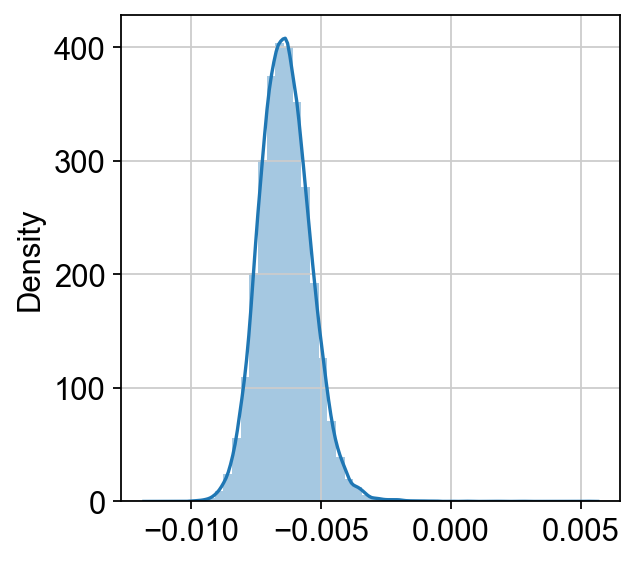

In [125]:
import umap
import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(Rs)
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/recons_Rs.pdf")

In [84]:
from scipy.stats import spearmanr
Rhos = []
for i in range(len(reconst)):
    Rhos.append(spearmanr(arrayed_data[i,:], reconst[i,:])[0])

/tmp/ipykernel_3251817/2701172272.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Rhos)


<AxesSubplot: ylabel='Density'>

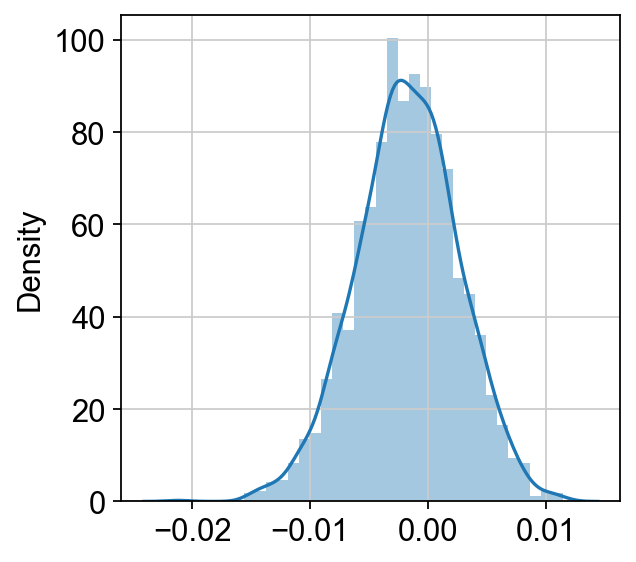

In [85]:
sns.distplot(Rhos)

In [86]:
mudf = pd.DataFrame(mumat)
mudf.columns = ["LV.mu.{}".format(each)
                            for each in range(numlvs)]

mudf.index = np.array(adata.obs.index, dtype="|U64")
mudf.head()

LV.mu.0   LV.mu.1   LV.mu.2   LV.mu.3   LV.mu.4  \
miR_1:AAACCCAAGGAGAGGC-1 -0.197290 -0.057178  0.178863 -0.688584 -0.565540   
miR_1:AAACCCAAGGTAAACT-1 -0.089145 -0.548122  0.421703 -0.019227 -0.187249   
miR_1:AAACCCACAACGATCT-1 -0.106618 -0.691369  0.541549  0.130757 -0.283387   
miR_1:AAACCCACACGATTCA-1  0.014459 -0.535433  0.093755 -0.487410 -0.405972   
miR_1:AAACCCACAGTCAACT-1 -0.941824 -0.526520  0.291302  0.337730  0.205037   

                           LV.mu.5   LV.mu.6   LV.mu.7   LV.mu.8   LV.mu.9  
miR_1:AAACCCAAGGAGAGGC-1  0.128651  0.237115  0.029637  0.319110  0.047999  
miR_1:AAACCCAAGGTAAACT-1 -0.109503  0.183740  0.359636 -0.218484 -0.376664  
miR_1:AAACCCACAACGATCT-1  0.299291  0.547984  0.077950 -0.345531  0.568042  
miR_1:AAACCCACACGATTCA-1  0.137352 -0.172084  0.228111 -0.232434 -0.031295  
miR_1:AAACCCACAGTCAACT-1 -0.161986  0.578135  0.980319 -0.176095 -0.130216

In [87]:
mudf.to_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/scMAVE_mu-matrix.tsv.gz",
                compression="gzip", sep="\t")

In [88]:
mumat = np.array(mudf.iloc[:, :numlvs])
reducer = umap.UMAP(n_neighbors=10, min_dist=0.45)
embedding = reducer.fit_transform(mumat)
umap_output = pd.DataFrame(embedding)
umap_output.columns = ["UMAP1", "UMAP2"]
umap_output["guide"] = list(adata.obs["guide"])
umap_output.index = mudf.index
umap_output.head()

UMAP1     UMAP2            guide
miR_1:AAACCCAAGGAGAGGC-1  2.550060  2.987736  hsa-miR-203a-3p
miR_1:AAACCCAAGGTAAACT-1  4.421403 -2.990399    hsa-miR-93-3p
miR_1:AAACCCACAACGATCT-1  3.136149 -2.084506  hsa-miR-130b-3p
miR_1:AAACCCACACGATTCA-1  1.130650  1.113929        TuD_NC_18
miR_1:AAACCCACAGTCAACT-1  5.767261 -2.639401  hsa-miR-147b-5p

In [91]:
umap_output.to_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/UMAP-OF-MU.tsv.gz",sep="\t", compression="gzip")

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np

umap_output = pd.read_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/UMAP-OF-MU.tsv.gz", sep = '\t')
umap_output

Unnamed: 0     UMAP1     UMAP2             guide  status
0      miR_1:AAACCCAAGGAGAGGC-1  2.550060  2.987736   hsa-miR-203a-3p       0
1      miR_1:AAACCCAAGGTAAACT-1  4.421403 -2.990399     hsa-miR-93-3p       0
2      miR_1:AAACCCACAACGATCT-1  3.136149 -2.084506   hsa-miR-130b-3p       0
3      miR_1:AAACCCACACGATTCA-1  1.130650  1.113929         TuD_NC_18       0
4      miR_1:AAACCCACAGTCAACT-1  5.767261 -2.639401   hsa-miR-147b-5p       0
...                         ...       ...       ...               ...     ...
29142  miR_3:TTTGGTTTCGGACTTA-1  7.880668  0.083867    hsa-miR-616-5p       0
29143  miR_3:TTTGTTGCACGCGTGT-1  0.770155 -0.324282    hsa-miR-361-5p       0
29144  miR_3:TTTGTTGCATAGATCC-1  5.330089  2.826629   hsa-miR-548o-3p       0
29145  miR_3:TTTGTTGGTCTAGTGT-1  8.033470 -0.262682   hsa-miR-3940-5p       0
29146  miR_3:TTTGTTGGTTTCCATT-1  8.717252  0.289343  hsa-miR-10527-5p       0

[29147 rows x 5 columns]

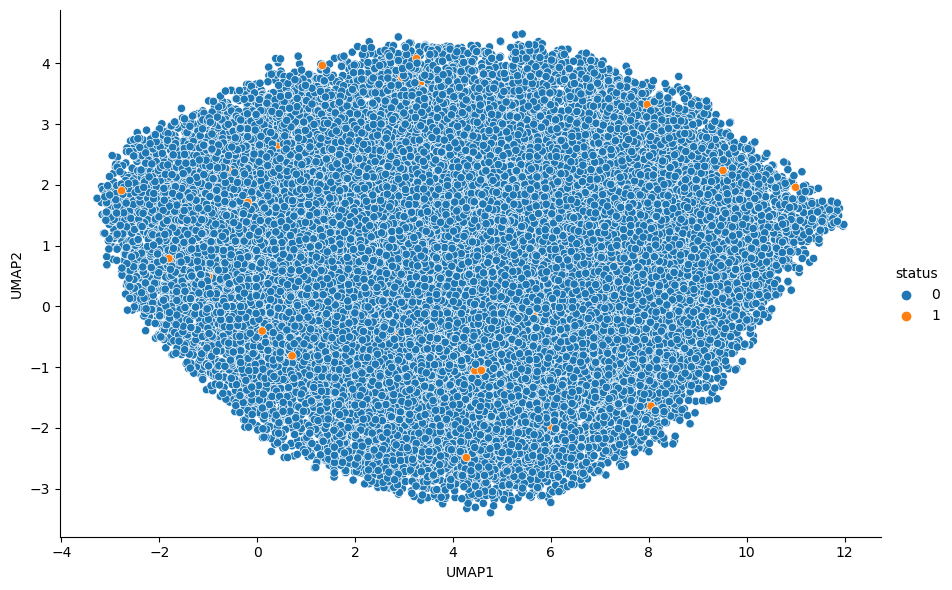

In [16]:
umap_output['status'] = np.where(umap_output.guide=="TuD_NC_04", 1, 0)
sns_plot = sns.relplot(
    x="UMAP1", y="UMAP2", hue="status", data=umap_output,
    height=6, aspect=1.5)

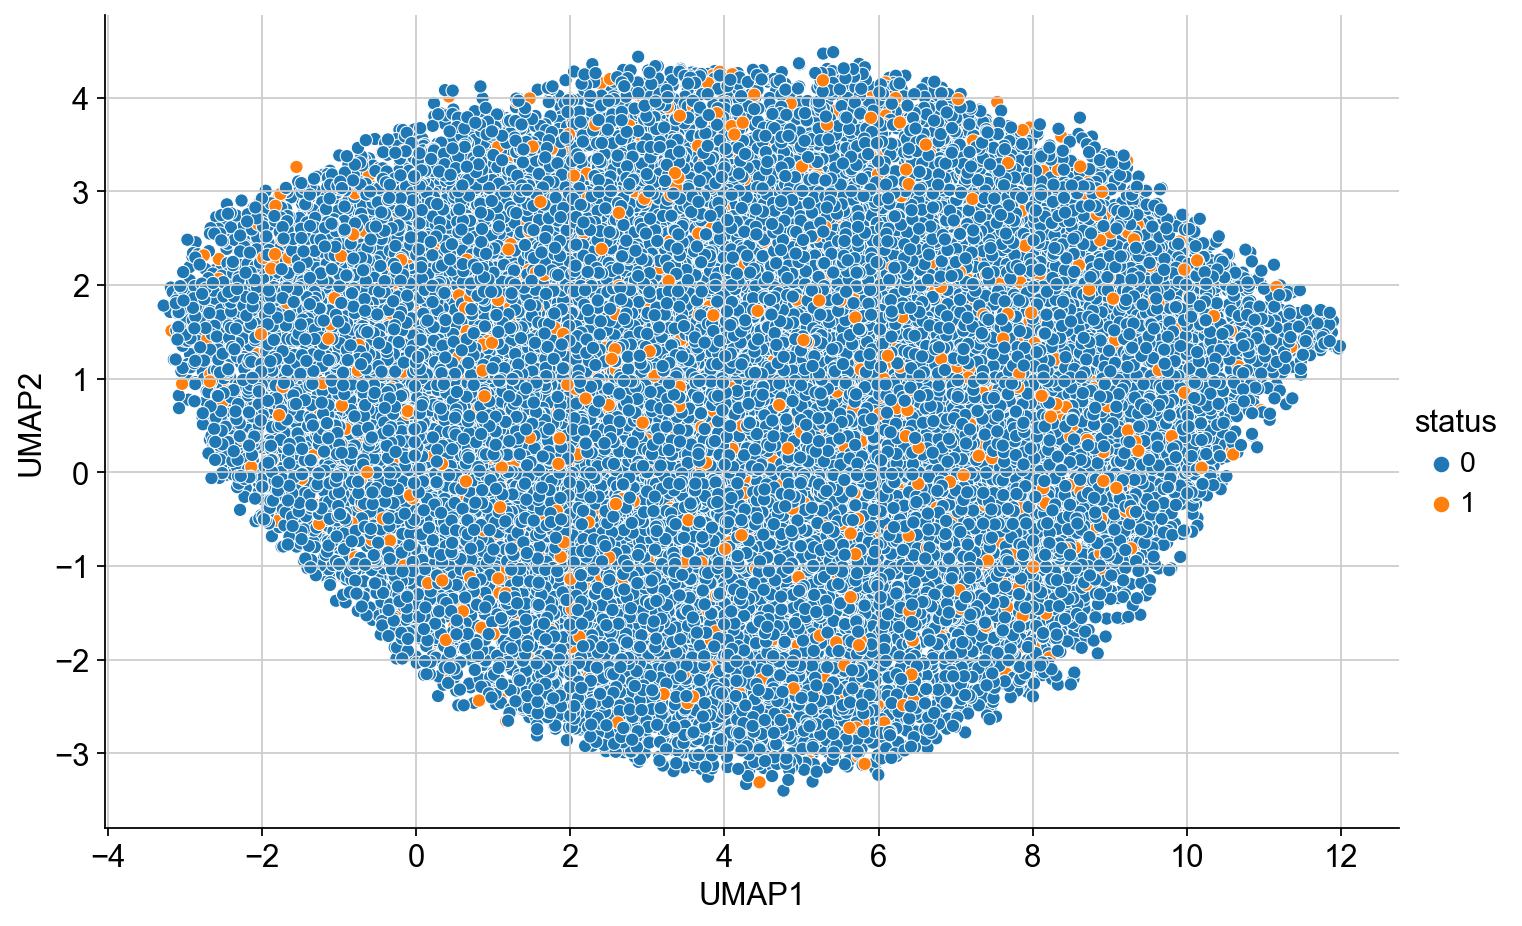

In [97]:
umap_output['status'] = np.where(umap_output.guide=="TuD_NC_01", 1, 0)
sns_plot = sns.relplot(
    x="UMAP1", y="UMAP2", hue="status", data=umap_output,
    height=6, aspect=1.5)

In [92]:
merged = mudf.merge(adata.obs[["guide"]], left_index=True, right_index=True).groupby(["guide"]).median()
merged.head()

LV.mu.0   LV.mu.1   LV.mu.2   LV.mu.3   LV.mu.4   LV.mu.5  \
guide                                                                   
TuD_NC_01 -0.222476 -0.280891  0.252976 -0.241833 -0.250219  0.217531   
TuD_NC_02 -0.181237 -0.272035  0.210332 -0.289030 -0.405331  0.202891   
TuD_NC_03 -0.198623 -0.293760  0.232001 -0.241203 -0.312426  0.139826   
TuD_NC_04 -0.201491 -0.310388  0.219993 -0.211777 -0.360819  0.264601   
TuD_NC_05 -0.133426 -0.330176  0.204045 -0.262524 -0.305507  0.215324   

            LV.mu.6   LV.mu.7   LV.mu.8   LV.mu.9  
guide                                              
TuD_NC_01  0.220002  0.255486 -0.332384 -0.184596  
TuD_NC_02  0.284472  0.302140 -0.338914 -0.217157  
TuD_NC_03  0.226392  0.257093 -0.386124 -0.244969  
TuD_NC_04  0.121747  0.303919 -0.294136 -0.157665  
TuD_NC_05  0.129079  0.263687 -0.293044 -0.247216

In [98]:
merged.loc["TuD_NC_01", ]

LV.mu.0   -0.222476
LV.mu.1   -0.280891
LV.mu.2    0.252976
LV.mu.3   -0.241833
LV.mu.4   -0.250219
LV.mu.5    0.217531
LV.mu.6    0.220002
LV.mu.7    0.255486
LV.mu.8   -0.332384
LV.mu.9   -0.184596
Name: TuD_NC_01, dtype: float64

In [99]:
#set negative as origin
merged = merged - merged.loc["TuD_NC_01", ]
merged.drop("TuD_NC_01", axis=0, inplace=True)

/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


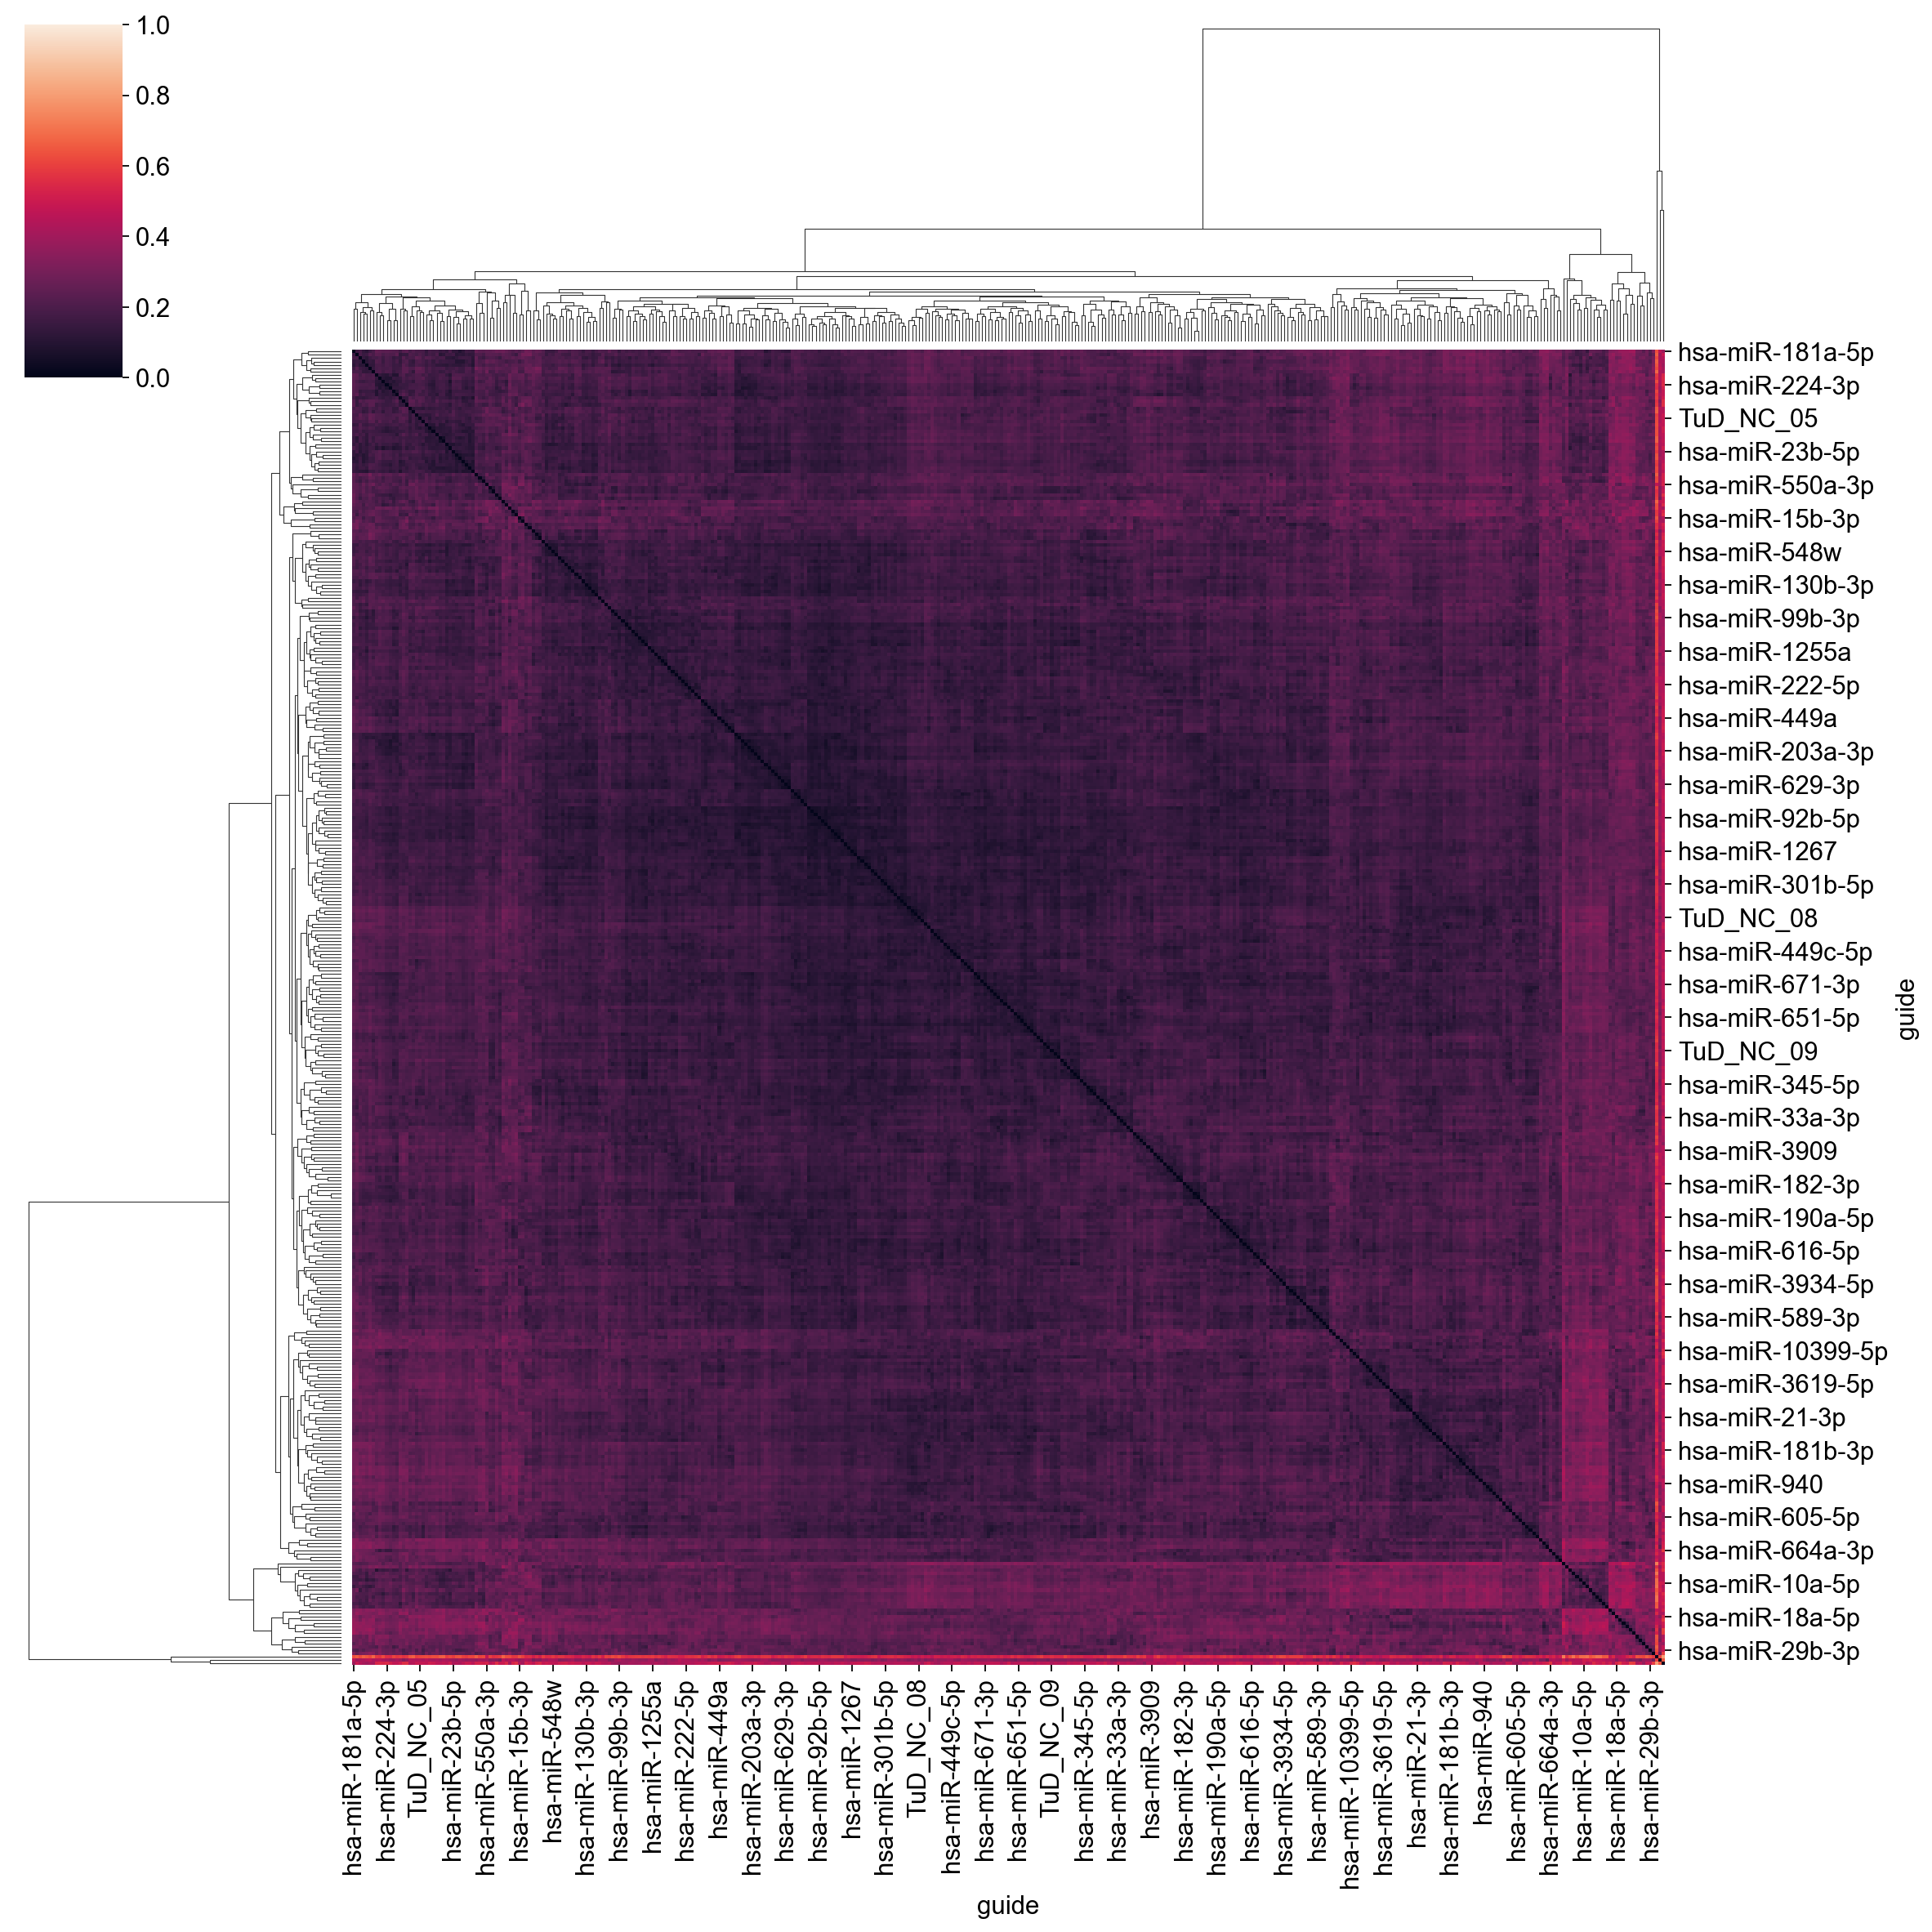

In [100]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

sns.clustermap(pd.DataFrame(squareform(pdist(merged)), index=merged.index, columns=merged.index), vmax=1, figsize=(15,15))
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/mudf_pairwise_distance.pdf")

In [101]:
pd.DataFrame(squareform(pdist(merged)), index=merged.index, columns=merged.index).to_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/mudf_pairwise_distance.tsv", sep="\t")

In [102]:
!head /home/ssobti/projects/mir_tud/output_data/mave_output/mudf_pairwise_distance.tsv

guide	TuD_NC_02	TuD_NC_03	TuD_NC_04	TuD_NC_05	TuD_NC_06	TuD_NC_07	TuD_NC_08	TuD_NC_09	TuD_NC_10	TuD_NC_11	TuD_NC_12	TuD_NC_13	TuD_NC_14	TuD_NC_15	TuD_NC_16	TuD_NC_17	TuD_NC_18	TuD_NC_19	TuD_NC_20	hsa-let-7a-2-3p	hsa-let-7a-5p	hsa-let-7b-3p	hsa-let-7d-3p	hsa-let-7f-2-3p	hsa-let-7i-3p	hsa-let-7i-5p	hsa-miR-7-1-3p	hsa-miR-7-5p	hsa-miR-9-3p	hsa-miR-9-5p	hsa-miR-10a-3p	hsa-miR-10a-5p	hsa-miR-15a-5p	hsa-miR-15b-3p	hsa-miR-15b-5p	hsa-miR-16-2-3p	hsa-miR-16-5p	hsa-miR-17-3p	hsa-miR-18a-3p	hsa-miR-18a-5p	hsa-miR-19b-1-5p	hsa-miR-19b-3p	hsa-miR-20a-3p	hsa-miR-20a-5p	hsa-miR-21-3p	hsa-miR-21-5p	hsa-miR-22-3p	hsa-miR-22-5p	hsa-miR-23a-5p	hsa-miR-23b-3p	hsa-miR-23b-5p	hsa-miR-24-1-5p	hsa-miR-24-2-5p	hsa-miR-24-3p	hsa-miR-25-3p	hsa-miR-25-5p	hsa-miR-26a-1-3p	hsa-miR-26a-2-3p	hsa-miR-26a-5p	hsa-miR-27a-5p	hsa-miR-27b-3p	hsa-miR-27b-5p	hsa-miR-28-3p	hsa-miR-28-5p	hsa-miR-29a-3p	hsa-miR-29a-5p	hsa-miR-29b-1-5p	hsa-miR-29b-3p	hsa-miR-29c-5p	hsa-miR-30a-3p	hsa-miR-30a-5p	hsa-miR-30b-3p	hsa-miR-30c-1-3p	h

/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


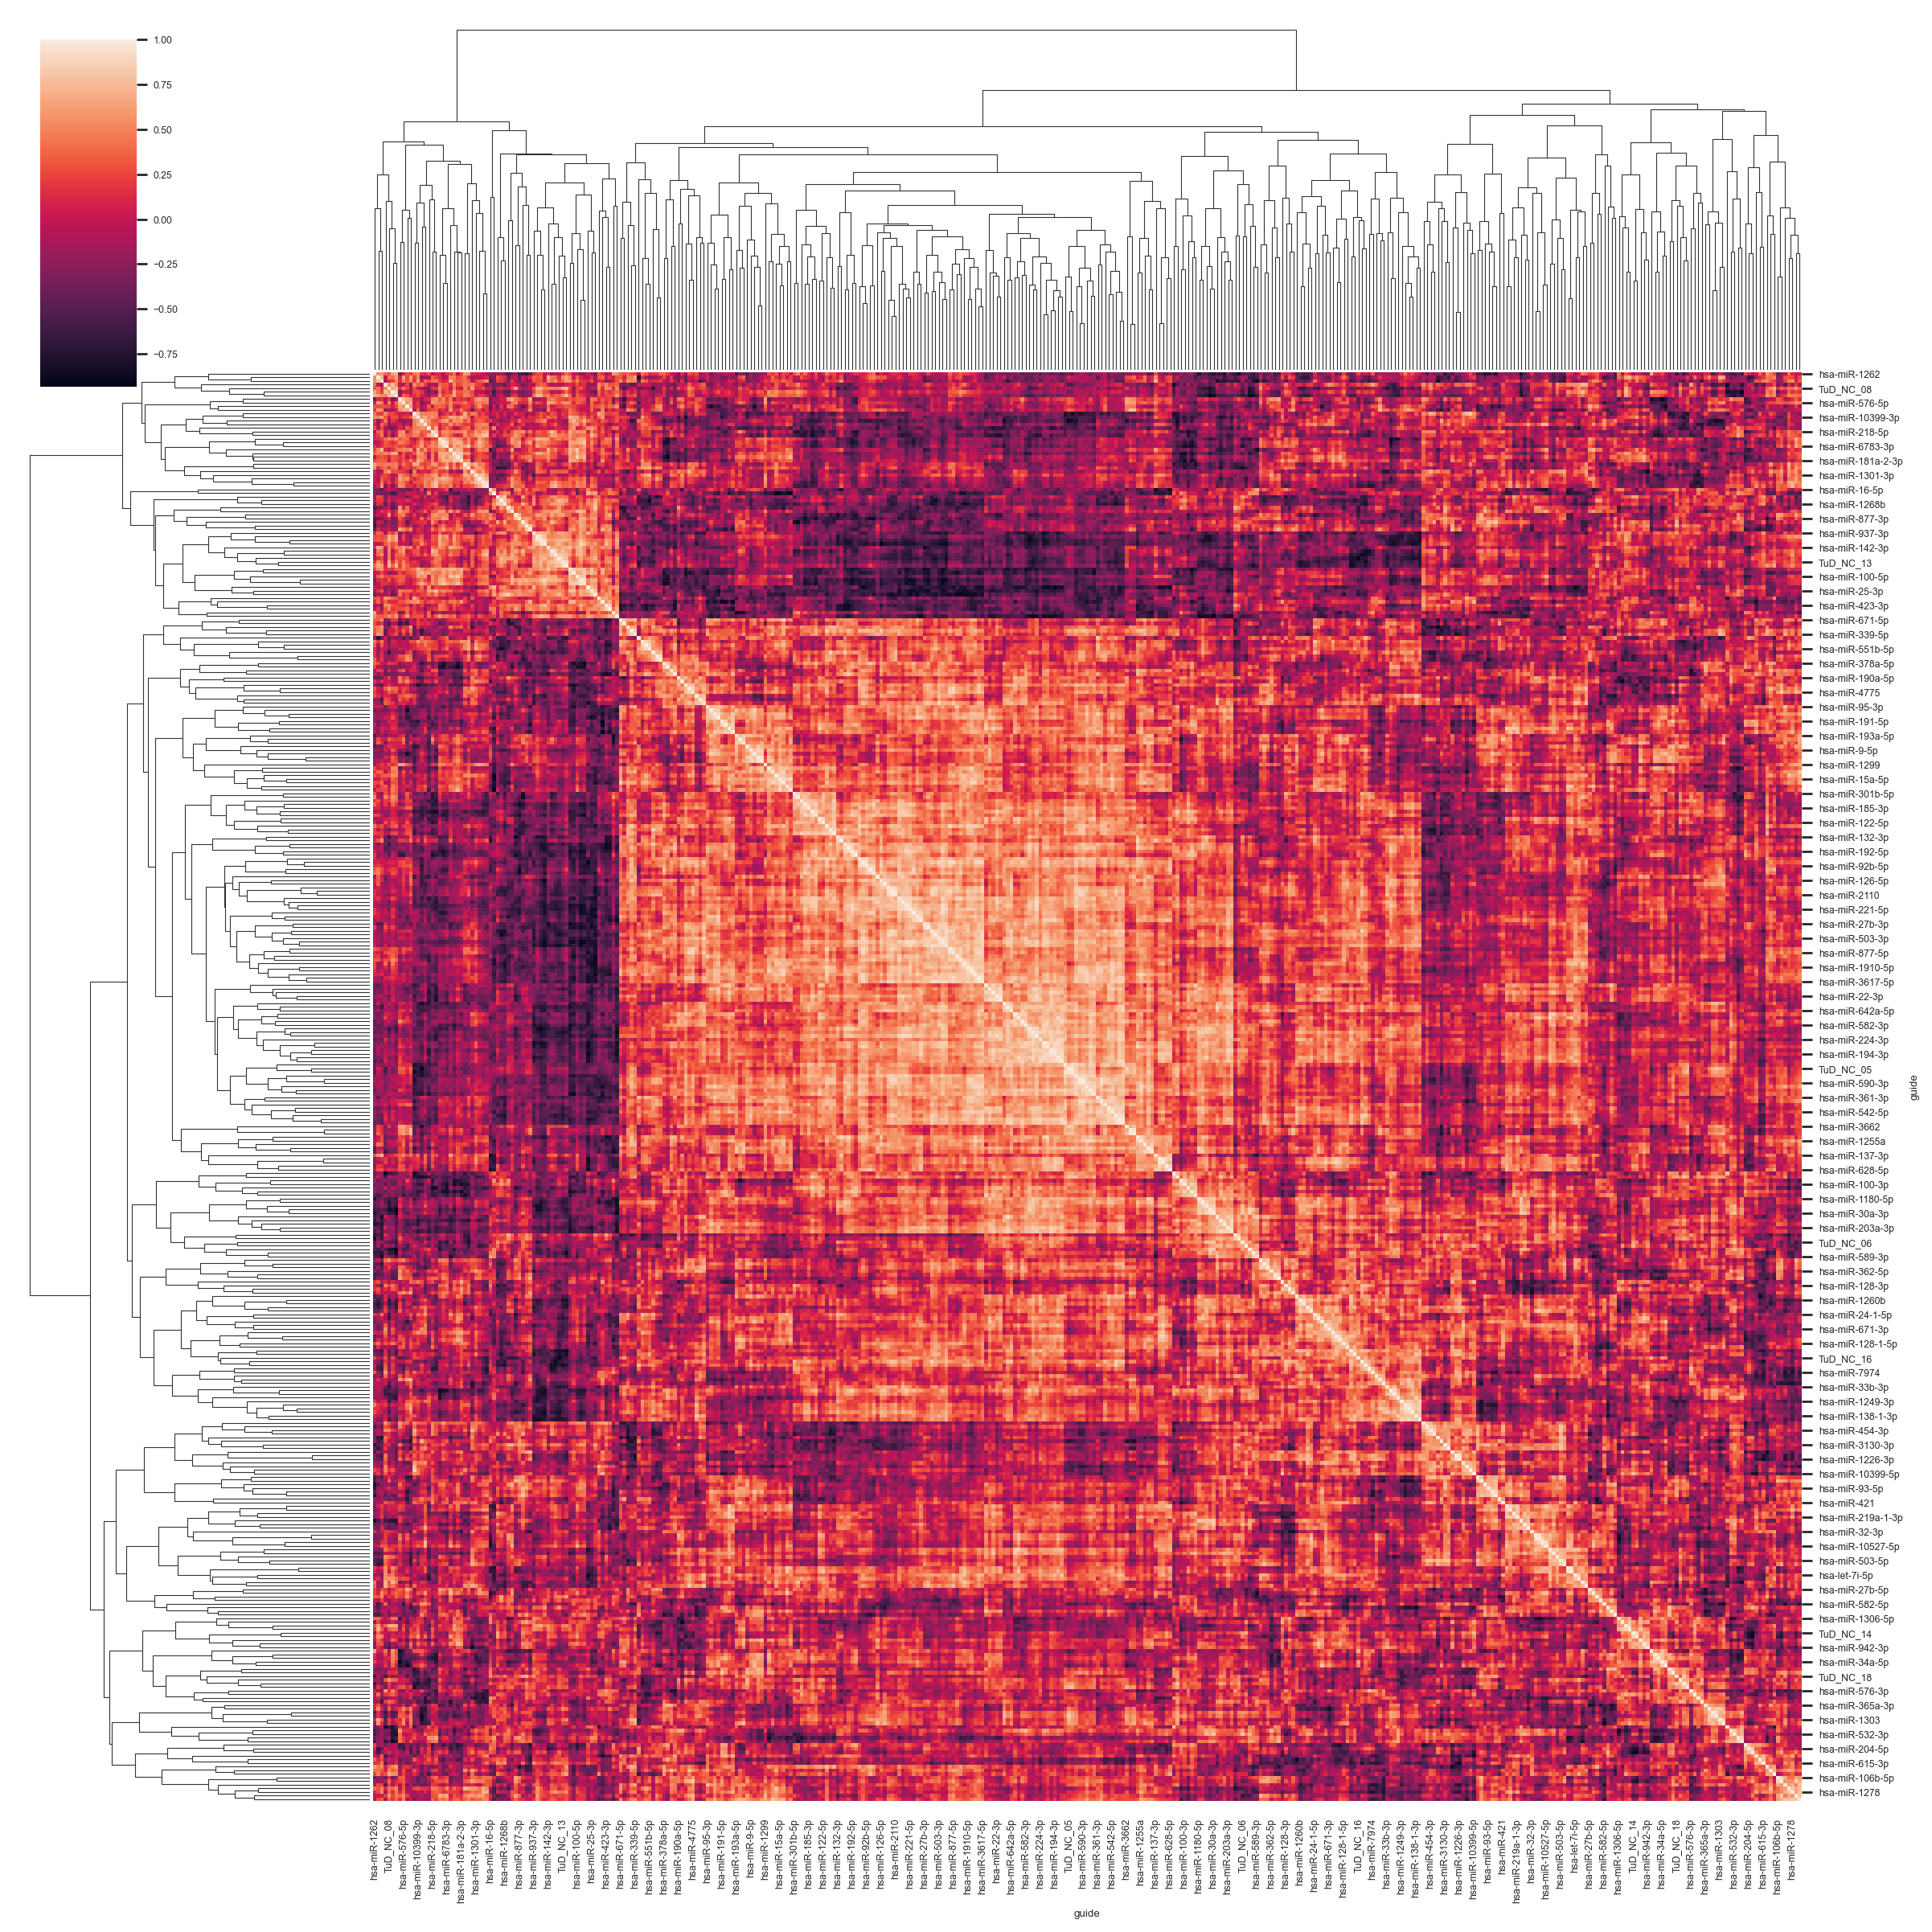

In [103]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=0.5)
sns.clustermap(merged.T.corr(), figsize=(15,15))
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/mudf_corr.pdf")

In [105]:
gmtmat_df.shape

(19073, 3725)

In [106]:
rbpdf = pd.DataFrame(rbp_act, columns=gmtmat_df.columns)
rbpdf.index = np.array(adata.obs.index, dtype="|U64")
rbpdf.head()

MIR153_5P   MIR8485   MIR3662    MIR607  MIR616_5P  \
miR_1:AAACCCAAGGAGAGGC-1   0.501246 -0.263636  0.449161  0.709582  -0.537852   
miR_1:AAACCCAAGGTAAACT-1   0.549779  0.535463  0.584631  0.123248  -0.785245   
miR_1:AAACCCACAACGATCT-1   1.212557  0.380955  0.545752  0.014358  -0.663598   
miR_1:AAACCCACACGATTCA-1   0.588452  0.182198  0.390233  0.253343  -1.313655   
miR_1:AAACCCACAGTCAACT-1   0.727612  0.140756  0.355022  1.199439  -1.160606   

                          MIR371B_5P  MIR373_5P  MIR6867_5P  MIR12136  \
miR_1:AAACCCAAGGAGAGGC-1    1.783670   1.430851   -1.291253 -1.615980   
miR_1:AAACCCAAGGTAAACT-1    1.274064   0.511374   -1.202536 -0.613337   
miR_1:AAACCCACAACGATCT-1    2.635233   1.123586   -1.553660 -1.326238   
miR_1:AAACCCACACGATTCA-1    3.023076   1.646113   -2.068620 -1.809651   
miR_1:AAACCCACAGTCAACT-1    1.545055  -0.484365   -1.613541 -1.103787   

                          MIR548AJ_3P_MIR548X_3P  ...  E2F1DP1RB_01  \
miR_1:AAACCCAAGGAGAGGC-1                0.358750  ...     -0.300151   
miR_1:AAACCCAAGGTAAACT-1                0.433127  ...     -0.637577   
miR_1:AAACCCACAACGATCT-1                1.523154  ...     -0.666448   
miR_1:AAACCCACACGATTCA-1                0.763330  ...     -0.640337   
miR_1:AAACCCACAGTCAACT-1                0.501947  ...     -0.455261   

                          E2F_Q3_01  E2F_Q4_01  E2F_Q6_01  E2F1_Q3_01  \
miR_1:AAACCCAAGGAGAGGC-1  -0.794294  -1.176354   1.341245    0.120401   
miR_1:AAACCCAAGGTAAACT-1  -0.311988  -1.134759   0.550320    0.360437   
miR_1:AAACCCACAACGATCT-1  -0.463296  -1.645535   1.346008    0.542362   
miR_1:AAACCCACACGATTCA-1  -0.843541  -2.153672   1.642894    0.418481   
miR_1:AAACCCACAGTCAACT-1  -0.011435  -1.152768  -0.041222    0.787978   

                          E2F1_Q4_01  E2F1_Q6_01  KTGGYRSGAA_UNKNOWN  \
miR_1:AAACCCAAGGAGAGGC-1    1.960734    1.919706           -0.197975   
miR_1:AAACCCAAGGTAAACT-1    1.800918    1.257850           -0.035505   
miR_1:AAACCCACAACGATCT-1    2.621628    2.086656           -0.150462   
miR_1:AAACCCACACGATTCA-1    2.956986    2.963027           -0.269340   
miR_1:AAACCCACAGTCAACT-1    1.096172    1.199803           -0.127177   

                          RRCCGTTA_UNKNOWN  SGCGSSAAA_E2F1DP2_01  
miR_1:AAACCCAAGGAGAGGC-1          0.359650              0.338586  
miR_1:AAACCCAAGGTAAACT-1          0.062289              0.375092  
miR_1:AAACCCACAACGATCT-1         -0.027322              0.428703  
miR_1:AAACCCACACGATTCA-1          0.243662              0.712907  
miR_1:AAACCCACAGTCAACT-1          0.165405              0.540748  

[5 rows x 3725 columns]

In [107]:
merged = rbpdf.merge(adata.obs[["guide"]], left_index=True, right_index=True).groupby(["guide"]).median()
merged.head()

MIR153_5P   MIR8485   MIR3662    MIR607  MIR616_5P  MIR371B_5P  \
guide                                                                       
TuD_NC_01   0.823648  0.163476  0.318982  0.398557  -0.990957    1.982305   
TuD_NC_02   0.984480  0.166628  0.287369  0.465579  -1.046952    2.057435   
TuD_NC_03   0.836719  0.114645  0.323859  0.421908  -0.970228    2.310562   
TuD_NC_04   0.947507  0.185746  0.304230  0.387146  -1.075271    2.122363   
TuD_NC_05   0.901289  0.186795  0.293713  0.425120  -0.979328    1.943639   

           MIR373_5P  MIR6867_5P  MIR12136  MIR548AJ_3P_MIR548X_3P  ...  \
guide                                                               ...   
TuD_NC_01   1.007729   -1.577878 -1.059392                0.649671  ...   
TuD_NC_02   1.053172   -1.794995 -1.048014                0.688828  ...   
TuD_NC_03   1.070799   -1.691630 -1.209458                0.599566  ...   
TuD_NC_04   1.067433   -1.766027 -1.217117                0.627518  ...   
TuD_NC_05   1.153815   -1.712716 -1.043739                0.612876  ...   

           E2F1DP1RB_01  E2F_Q3_01  E2F_Q4_01  E2F_Q6_01  E2F1_Q3_01  \
guide                                                                  
TuD_NC_01     -0.551928  -0.505987  -1.510860   0.907769    0.325220   
TuD_NC_02     -0.685788  -0.572916  -1.637787   0.990551    0.435921   
TuD_NC_03     -0.583505  -0.470020  -1.579297   0.974345    0.345087   
TuD_NC_04     -0.662021  -0.456177  -1.575876   0.950272    0.347107   
TuD_NC_05     -0.555199  -0.546122  -1.456589   0.981455    0.326031   

           E2F1_Q4_01  E2F1_Q6_01  KTGGYRSGAA_UNKNOWN  RRCCGTTA_UNKNOWN  \
guide                                                                     
TuD_NC_01    2.156885    2.032204           -0.135229          0.127469   
TuD_NC_02    2.302918    2.110930           -0.156238          0.128087   
TuD_NC_03    2.488754    2.141868           -0.145728          0.153455   
TuD_NC_04    2.353951    2.106352           -0.130528          0.124169   
TuD_NC_05    2.101255    2.127313           -0.134841          0.150757   

           SGCGSSAAA_E2F1DP2_01  
guide                            
TuD_NC_01              0.428444  
TuD_NC_02              0.590552  
TuD_NC_03              0.486042  
TuD_NC_04              0.454012  
TuD_NC_05              0.402339  

[5 rows x 3725 columns]

/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


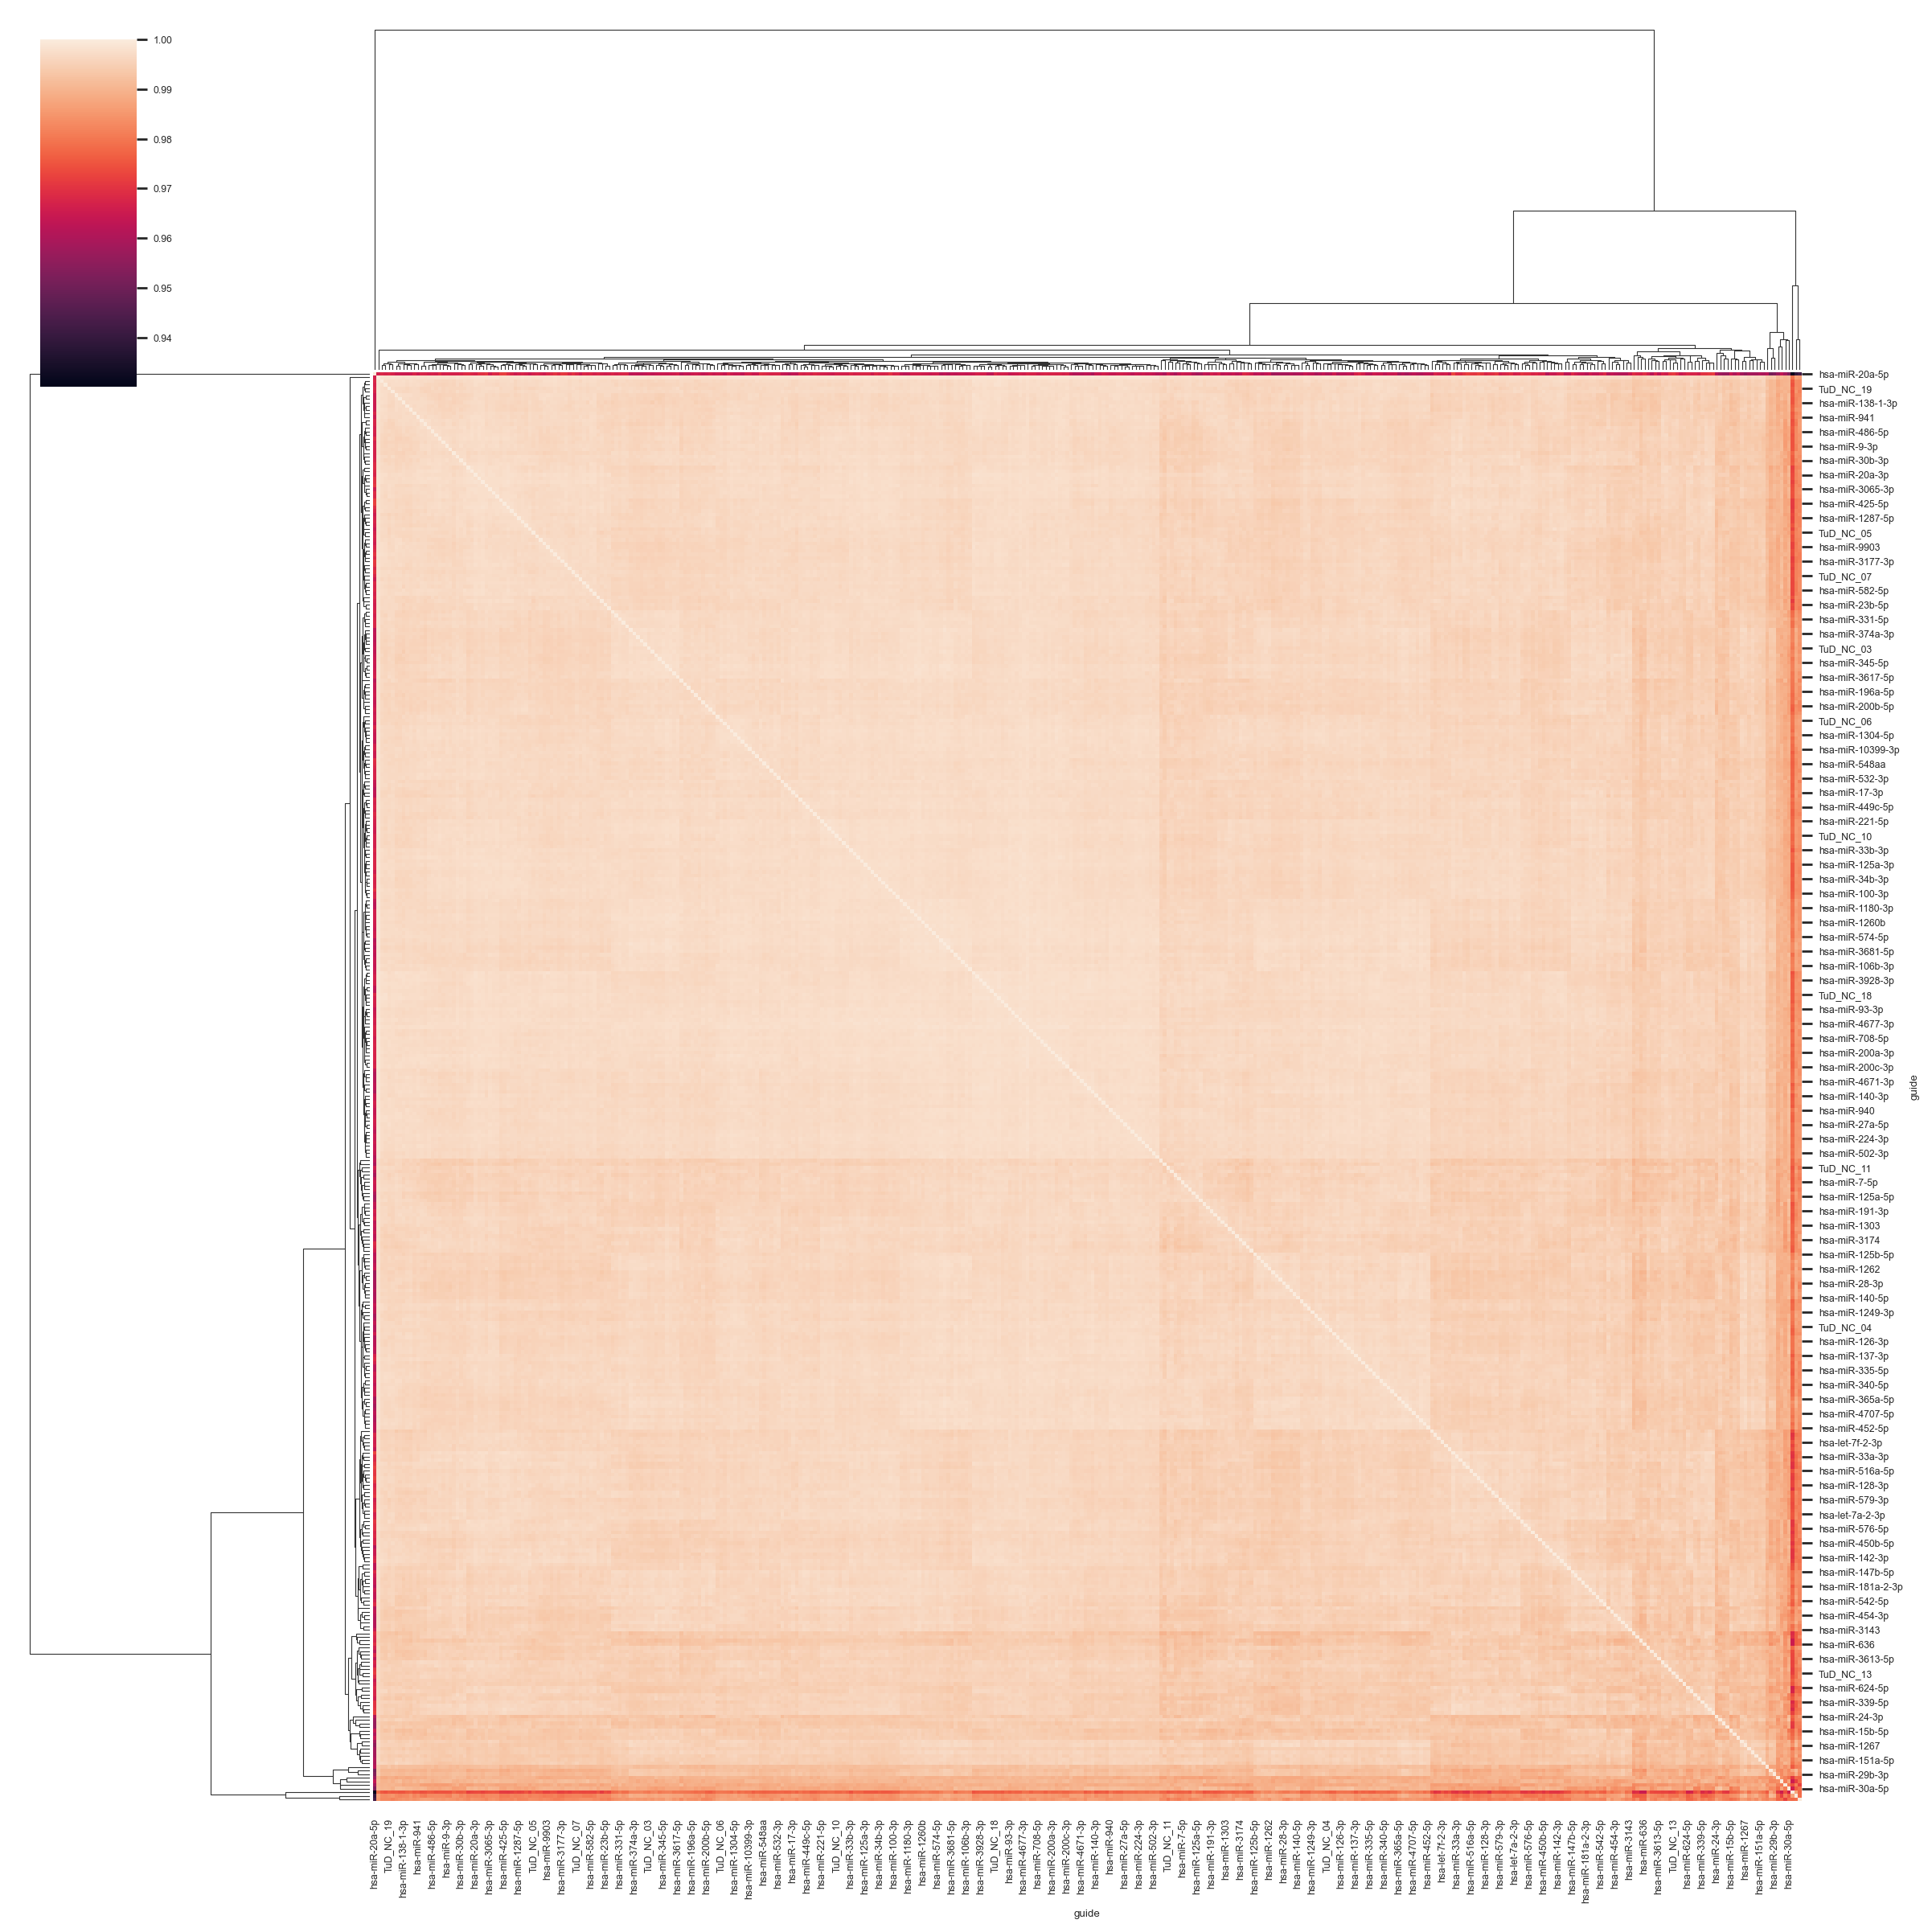

In [108]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=0.5)
sns.clustermap(merged.T.corr(), figsize=(15,15))
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/rbpdf_corr.pdf")